In [14]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeRegressor
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import (LinearRegression, 
                                  Ridge, Lasso, RidgeCV, LassoCV)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

import matplotlib.pyplot as plt
import seaborn as sns
import plotly 
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import iplot, init_notebook_mode
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
plotly.tools.set_credentials_file(username='uruesp', api_key='V5JgY3bZVrHNSq9LLO4Y')

import pickle
import eli5
import warnings
warnings.filterwarnings('ignore',category=UserWarning)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use('seaborn-darkgrid')

In the following lines I'll load the models and the data needed:

In [15]:
lasso = pickle.load(open('lasso.sav', 'rb'))

In [16]:
bagging_tree = pickle.load(open('bagging_tree.sav', 'rb'))

In [17]:
final_with_preds = pd.read_csv('/Users/gonzaloferreiro/Documents/GA_Materials/DS_Inmersive/DSI8-lessons/projects/project-capstone/Moving_forward/Final_datasets/Working_files/Final_with_predictions.csv')

In [18]:
final_with_clubs = pd.read_csv('/Users/gonzaloferreiro/Documents/GA_Materials/DS_Inmersive/DSI8-lessons/projects/project-capstone/Moving_forward/Final_datasets/Working_files/final_with_clubes.csv')

In [19]:
mega_links = pd.read_csv('/Users/gonzaloferreiro/Documents/GA_Materials/DS_Inmersive/DSI8-lessons/projects/project-capstone/Moving_forward/Final_datasets/Working_files/mega_links.csv',header=None)
mega_dataset = pd.read_csv('/Users/gonzaloferreiro/Documents/GA_Materials/DS_Inmersive/DSI8-lessons/projects/project-capstone/Moving_forward/Final_datasets/Working_files/mega_dataset.csv')
y_mega = mega_dataset.pop('current_log_y')

In [20]:
X_train_mega_std = pd.read_csv('/Users/gonzaloferreiro/Documents/GA_Materials/DS_Inmersive/DSI8-lessons/projects/project-capstone/Moving_forward/Final_datasets/Working_files/Train-test_datasets/X_train_mega_std')
X_test_mega_std = pd.read_csv('/Users/gonzaloferreiro/Documents/GA_Materials/DS_Inmersive/DSI8-lessons/projects/project-capstone/Moving_forward/Final_datasets/Working_files/Train-test_datasets/X_test_mega_std')
y_train_mega = pd.read_csv('/Users/gonzaloferreiro/Documents/GA_Materials/DS_Inmersive/DSI8-lessons/projects/project-capstone/Moving_forward/Final_datasets/Working_files/Train-test_datasets/y_train_mega',header=None)
y_test_mega = pd.read_csv('/Users/gonzaloferreiro/Documents/GA_Materials/DS_Inmersive/DSI8-lessons/projects/project-capstone/Moving_forward/Final_datasets/Working_files/Train-test_datasets/y_test_mega',header=None)
mega_std = pd.read_csv('/Users/gonzaloferreiro/Documents/GA_Materials/DS_Inmersive/DSI8-lessons/projects/project-capstone/Moving_forward/Final_datasets/Working_files/Train-test_datasets/mega_std')

## Feature importance

### Through decision trees

As this Decision Tree Regressor was built as a combination of bagging (with 2.000 iterations) and grid search, it's really kind of a black box to find the most important features. However, we can just grab the best estimator for each iteration, check the feature importance it (taking into account that each one of them are grabbing a different set of features) and average the results to at least have an idea of what's happening inside that box.

#### Regular feature importance

In [21]:
dumies = ['team_clas', 'league', 'pos_def', 'pref_side', 'type_agent','age_group','last_team']

In [69]:
first = np.array(bagging_tree.best_estimator_.estimators_[0].feature_importances_)
features_df = pd.DataFrame(first[None,:],columns=X_train_mega_std.columns)

In [23]:
its = len(bagging_tree.best_estimator_.estimators_)
for each in range(1,its):
    featured = np.array(bagging_tree.best_estimator_.estimators_[each].feature_importances_)
    appender = pd.DataFrame(featured[None,:],columns=X_train_mega_std.columns)
    features_df = features_df.append(appender)
    

In [24]:
feature_imp = pd.DataFrame(features_df.describe().loc['mean',:])

In [25]:
feature_imp = feature_imp.sort_values(by='mean', ascending=False)

In [26]:
names_res=[]
for coef in feature_imp.index:
    append = False
    for each in dumies:
        if each in coef:
            names_res.append(each)
            append = True
    if not append:
        names_res.append(coef)

In [27]:
feature_imp['variable'] = names_res
feature_imp_top = feature_imp.head(25)

In [28]:
grouped_features = feature_imp.groupby('variable').sum().sort_values(by='mean',ascending=False).head(25)

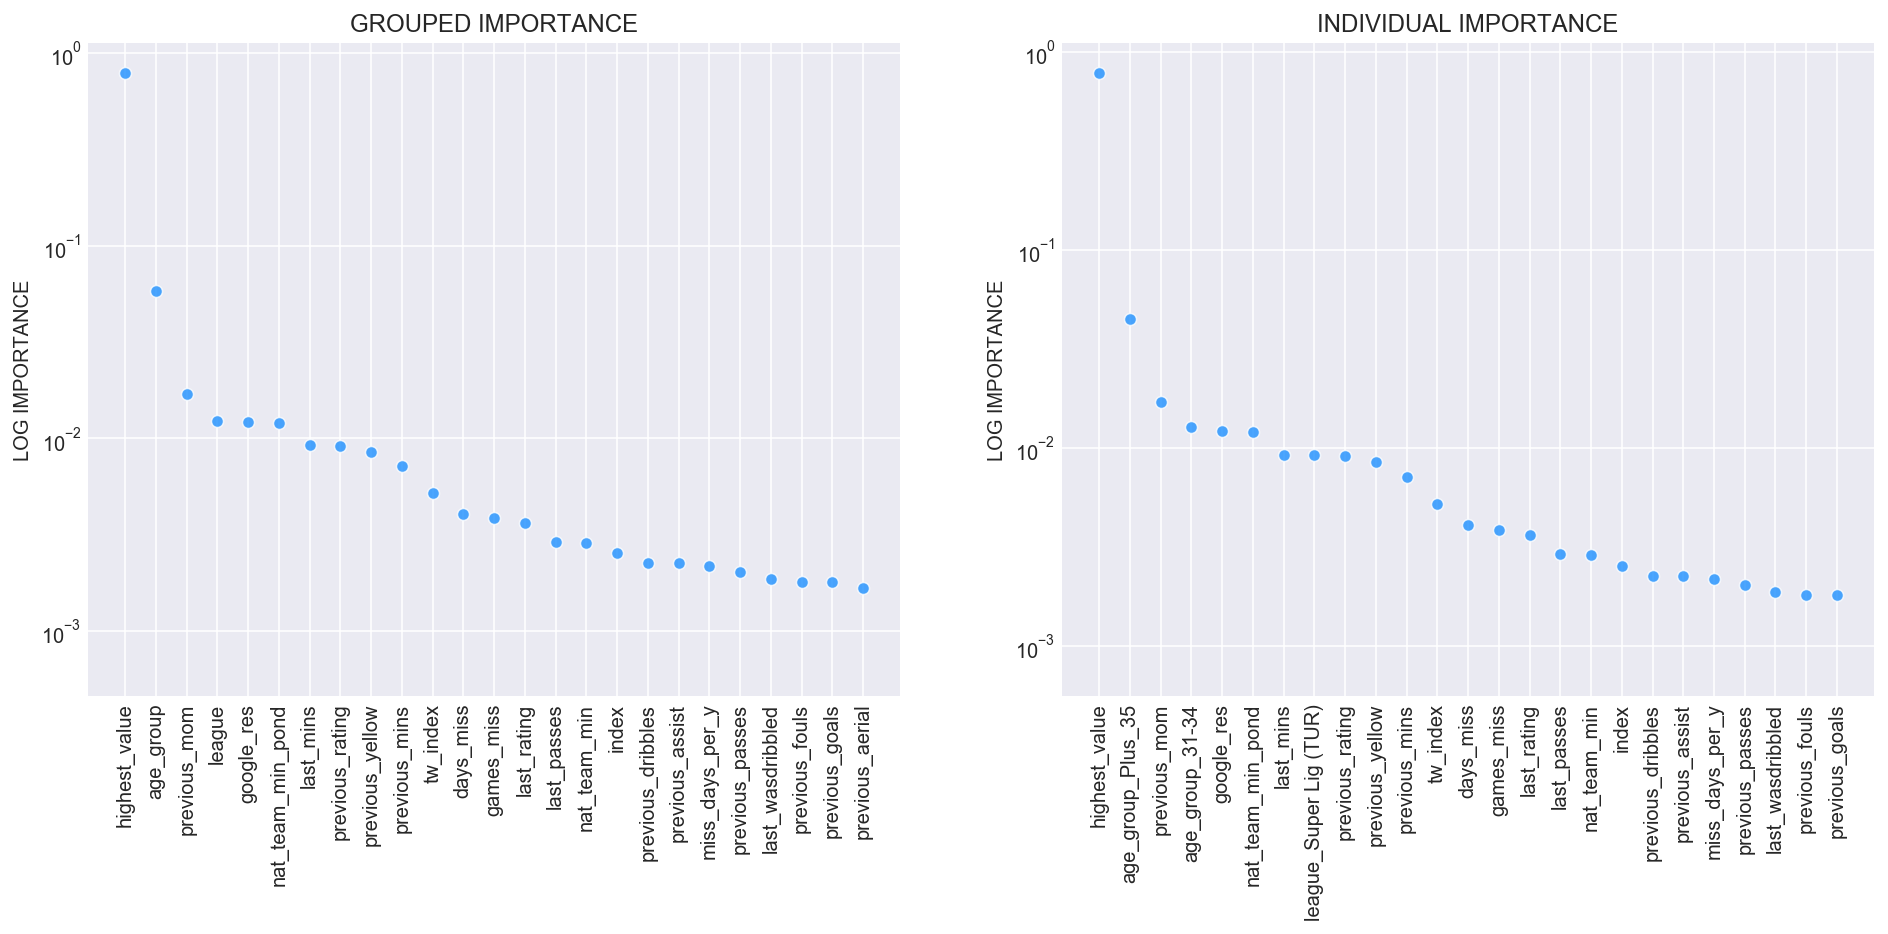

In [29]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))

sns.scatterplot(x=feature_imp_top.index, 
                y=feature_imp_top['mean'], 
                ax=ax[1],color='dodgerblue', alpha=0.8);
sns.scatterplot(x=grouped_features.index, 
                y=grouped_features['mean'], 
                ax=ax[0],color='dodgerblue', alpha=0.8);


ax[0].set_title('GROUPED IMPORTANCE')
ax[1].set_title('INDIVIDUAL IMPORTANCE')

ax[0].set_ylabel('LOG IMPORTANCE')    
ax[0].set_xlabel('')
ax[1].set_ylabel('LOG IMPORTANCE')    
ax[1].set_xlabel('')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
    plt.yscale('log')

#### What happens if we only model on 'highest_value'

In [30]:
X_train_only_highest = X_train_mega_std[['highest_value']]
X_test_only_highest = X_test_mega_std[['highest_value']]

In [31]:
tree_only_high = DecisionTreeRegressor(random_state=123)

In [32]:
tree_params_only_high = {'max_depth': [1,2,3],
                       'max_features': [1],
                       'max_leaf_nodes': [2,3],
                       'min_samples_leaf': [1,2,3],
                       'min_samples_split': [2,5,10]}
          

tree_grid_only_high = GridSearchCV(
        estimator=tree_only_high,
        param_grid=tree_params_only_high, cv=3)

tree_grid_only_high.fit(X_train_only_highest, y_train_mega)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=123, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [1, 2, 3], 'max_features': [1], 'max_leaf_nodes': [2, 3], 'min_samples_leaf': [1, 2, 3], 'min_samples_split': [2, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [33]:
tree_grid_only_high.score(X_train_only_highest, y_train_mega)

0.6329074862126878

In [34]:
tree_grid_only_high.score(X_test_only_highest, y_test_mega)

0.5933401585609975

#### What happens if we remove 'highest_value'

In [35]:
basic_tree_w_high = DecisionTreeRegressor(random_state=123)
bagging_tree_w_high = BaggingRegressor(base_estimator=basic_tree_w_high, random_state=1, n_estimators=1000)

In [36]:
X_train_w_highest = X_train_mega_std.drop(labels='highest_value',axis=1)
X_test_w_highest = X_test_mega_std.drop(labels='highest_value',axis=1)

In [37]:
bagging_tree_params_w_high = {'base_estimator__max_depth': [30],
                       'base_estimator__max_features': [0.90],
                       'base_estimator__max_leaf_nodes': [85],
                       'base_estimator__min_samples_leaf': [1],
                       'base_estimator__min_samples_split': [10],
                       #'bootstrap': [True,False],
                       #'bootstrap_features': [True,False],
                       'max_features': [1.0],
                       'max_samples': [1.0]}
          

bagging_tree_grid_w_high = GridSearchCV(
        estimator=bagging_tree_w_high,
        param_grid=bagging_tree_params_w_high, cv=3)

bagging_tree_grid_w_high.fit(X_train_w_highest, y_train_mega)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
       ...estimators=1000, n_jobs=None, oob_score=False,
         random_state=1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'base_estimator__max_depth': [30], 'base_estimator__max_features': [0.9], 'base_estimator__max_leaf_nodes': [85], 'base_estimator__min_samples_leaf': [1], 'base_estimator__min_samples_split': [10], 'max_features': [1.0], 'max_samples': [1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [38]:
bagging_tree_grid_w_high.best_estimator_.score(X_train_w_highest, y_train_mega)

0.8844646168668306

In [39]:
bagging_tree_grid_w_high.best_estimator_.score(X_test_w_highest, y_test_mega)

0.6604327728291164

In summary:

**Only with it:**
0.63 on the training group and 0.59 on the test group. Pretty amazing for just one feature, but not good enough to have reasonable predictions

**Without it:**
The picture is not much better: 0.88 on the train group, but only 0.66 on the test

Hence we need the combination of all the features, to arrive at our previous scores.

### Through Lasso

We already saw that in the average feature importance of all our trees, the Highest Value of a player in his carreer is by far the most important feature. However, that way of analyzing feature importance it's not completely right or convient. That's why, let's explore a few more ways of checking out that.

Let's start by analyzing the coefficients of our Lasso model, which applied some regularization strength to our dataset mixing the best predictors out of the initial dataset and the teams dataset.

In [40]:
lasso_pred = lasso.predict(X_test_mega_std)

In [41]:
lasso_res = y_test_mega.iloc[:,0] - lasso_pred

/Users/gonzaloferreiro/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



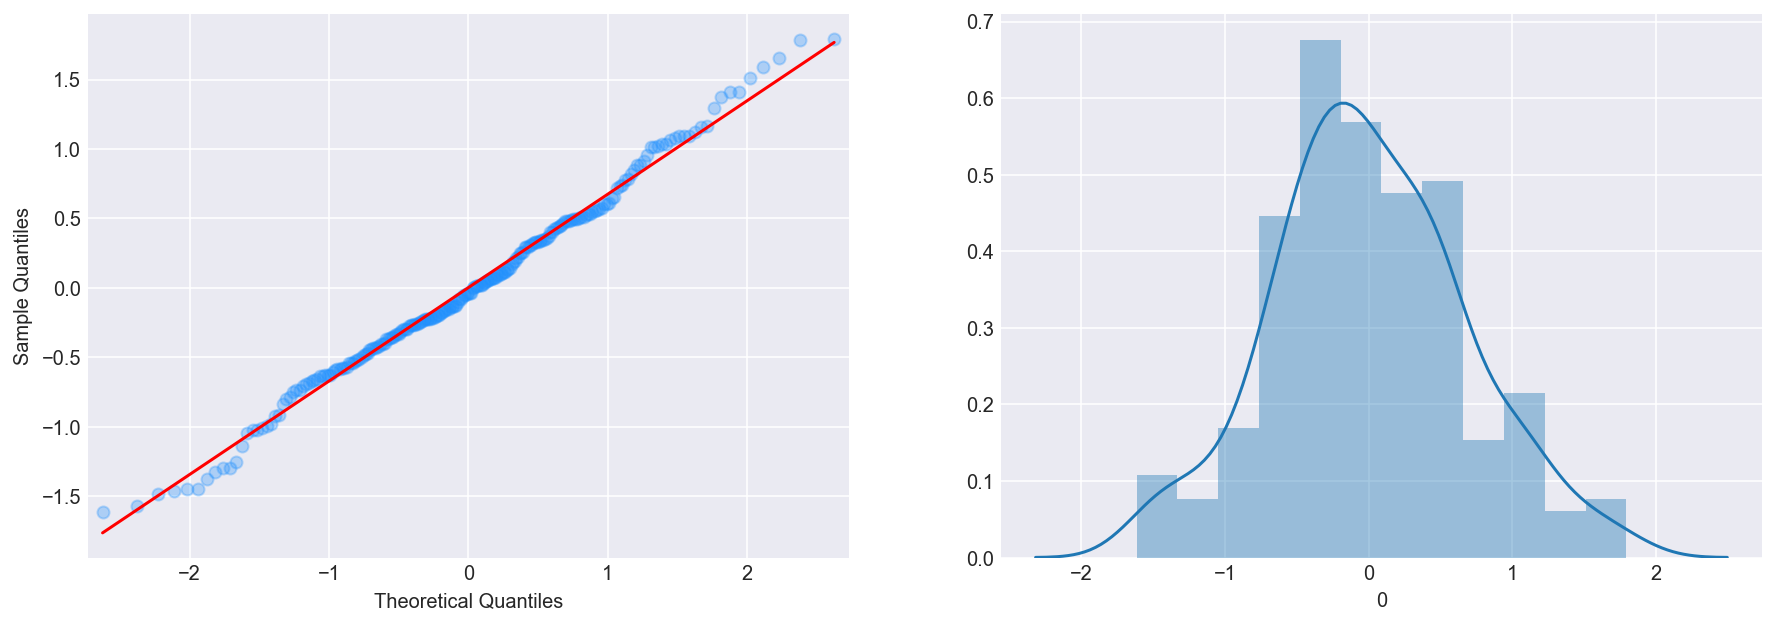

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
qqplot(lasso_res, line='s', ax=ax[0], c='dodgerblue', alpha=0.3);
sns.distplot(lasso_res, ax=ax[1]);
plt.show()

Our residuals are kind of normal distribiuted, so we can study our coefficients with pretty much confidence.

In [43]:
df_coef = pd.DataFrame({'coef': lasso.coef_,
                        'variable': X_test_mega_std.columns,
                        'coef_abs': np.abs(lasso.coef_)})

In [44]:
names_res=[]
for coef in df_coef.variable:
    append = False
    for each in dumies:
        if each in coef:
            names_res.append(each)
            append = True
    if not append:
        names_res.append(coef)

In [45]:
df_coef['original'] = names_res
df_coef_lasso_top = df_coef.sort_values(by='coef_abs', ascending=False).head(25)

In [46]:
original_importance = df_coef.groupby('original').sum()
original_importance.reset_index(inplace=True)
original_importance_top = original_importance.sort_values(by='coef_abs',ascending=False).head(25)

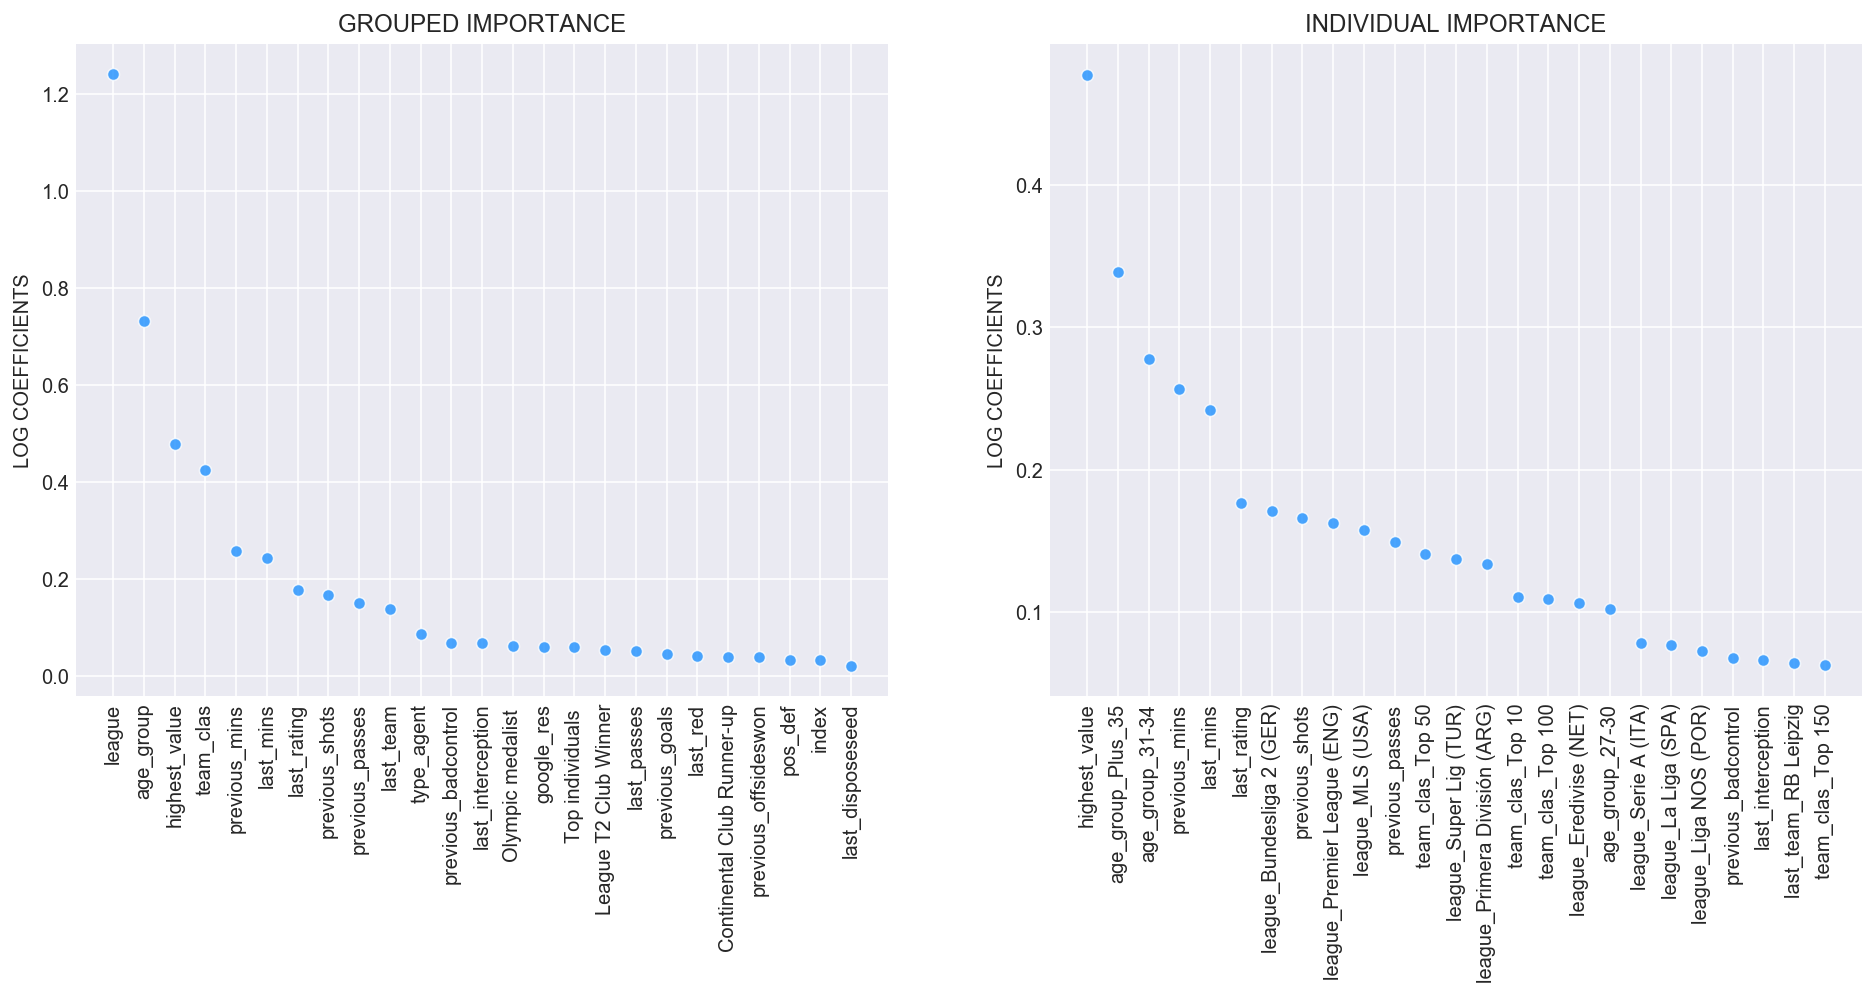

In [47]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))

sns.scatterplot(x=df_coef_lasso_top.variable, 
                y=df_coef_lasso_top.coef_abs, 
                ax=ax[1],color='dodgerblue', alpha=0.8,markers=False)
sns.scatterplot(x=original_importance_top.original, 
                y=original_importance_top.coef_abs, 
                ax=ax[0],color='dodgerblue', alpha=0.8,markers=False);


ax[0].set_title('GROUPED IMPORTANCE')
ax[1].set_title('INDIVIDUAL IMPORTANCE')

ax[0].set_ylabel('LOG COEFFICIENTS')    
ax[0].set_xlabel('')
ax[1].set_ylabel('LOG COEFFICIENTS')    
ax[1].set_xlabel('')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
    #plt.yscale('log')

### Through Permutation Importance

Permutation Importance gives us a way to compute feature importances for any black-box estimator by measuring how score decreases when a feature is not available. The idea is the following: feature importance can be measured by looking at how much the score decreases when a feature is not available. To do that one can remove feature from the dataset, re-train the estimator and check the score. That's why this method of knowing feature importance is also known as “Mean Decrease Accuracy (MDA)”.

In [48]:
perm = PermutationImportance(bagging_tree, random_state=1).fit(X_train_mega_std, y_train_mega)

In [49]:
perm_feature_importance_std = pd.DataFrame(perm.feature_importances_std_,
                                  index=X_train_mega_std.columns,
                                  columns=['Coef'])

In [50]:
perm_feature_importance = pd.DataFrame(perm.feature_importances_,
                                  index=X_train_mega_std.columns,
                                  columns=['Coef'])

In [51]:
names_res=[]
for coef in perm_feature_importance.index:
    append = False
    for each in dumies:
        if each in coef:
            names_res.append(each)
            append = True
    if not append:
        names_res.append(coef)

In [52]:
perm_feature_importance['variable'] = names_res
grouped_perm = perm_feature_importance.groupby('variable').sum()
grouped_perm.reset_index(inplace=True)
top_grouped_perm = grouped_perm.sort_values(by='Coef',ascending=False).head(25)

In [53]:
perm_top_std = perm_feature_importance_std.sort_values(by='Coef',ascending=False).head(25)
perm_top_imp = perm_feature_importance.sort_values(by='Coef',ascending=False).head(25)

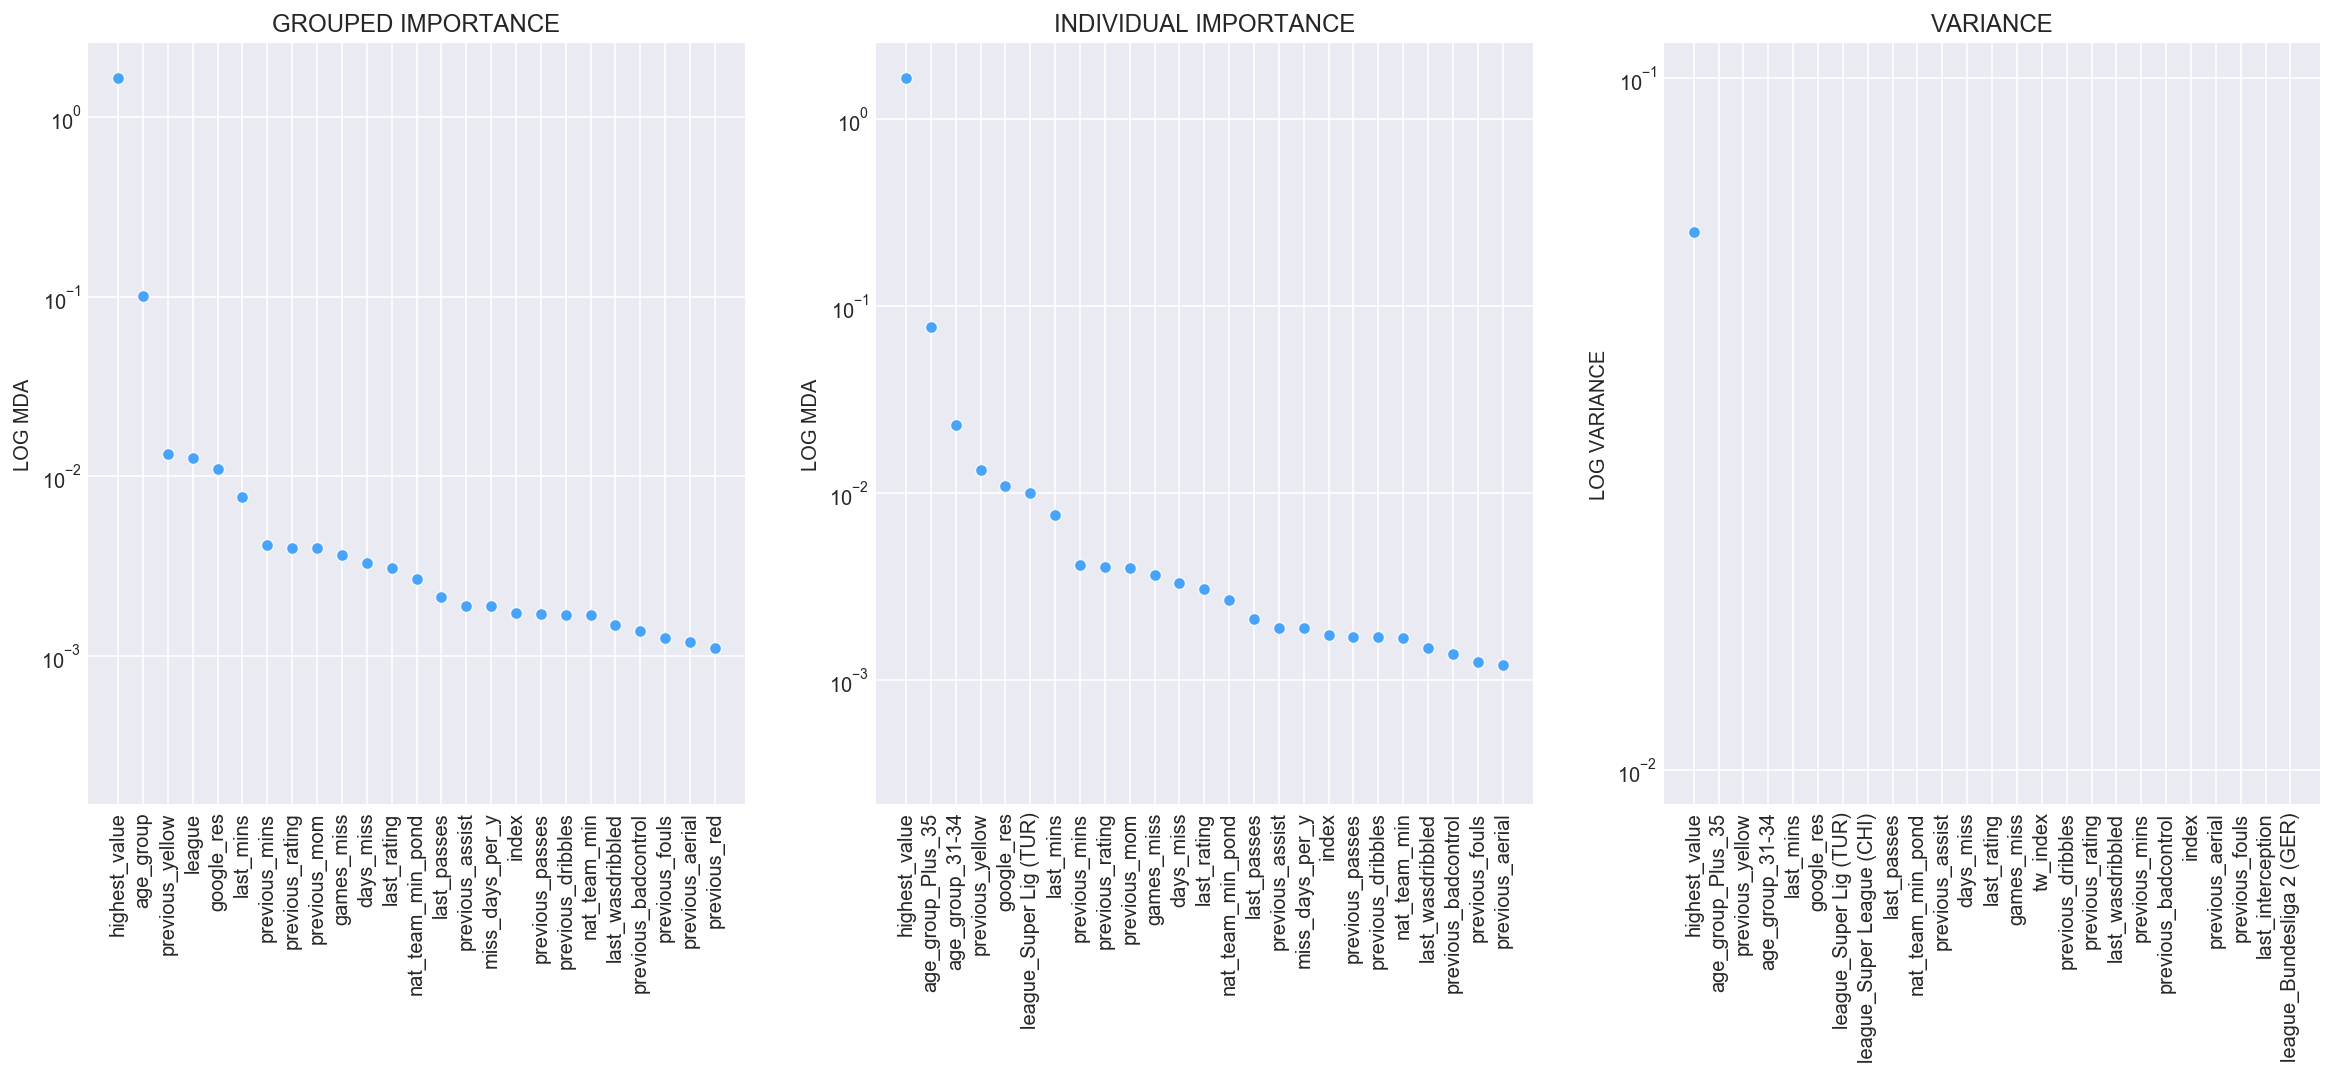

In [54]:
fig, ax_ = plt.subplots(ncols=3, figsize=(20,7))

sns.scatterplot(x=top_grouped_perm.variable, 
                y=top_grouped_perm.Coef, 
                ax=ax_[0],color='dodgerblue', alpha=0.8);
sns.scatterplot(x=perm_top_imp.index, 
                y=perm_top_imp.Coef, 
                ax=ax_[1],color='dodgerblue', alpha=0.8);
sns.scatterplot(x=perm_top_std.index, 
                y=perm_top_std.Coef, 
                ax=ax_[2],color='dodgerblue', alpha=0.8);


ax_[0].set_title('GROUPED IMPORTANCE')
ax_[1].set_title('INDIVIDUAL IMPORTANCE')
ax_[2].set_title('VARIANCE')

ax_[0].set_ylabel('LOG MDA')    
ax_[0].set_xlabel('')
ax_[1].set_ylabel('LOG MDA')    
ax_[1].set_xlabel('')
ax_[2].set_ylabel('LOG VARIANCE')    
ax_[2].set_xlabel('')

for ax_ in fig.axes:
    plt.sca(ax_)
    plt.xticks(rotation=90)
    plt.yscale('log')

#### Conclusiones on feature importance

In [55]:
grouped_features['pond'] = [x/np.sum(grouped_features['mean']) for x in grouped_features['mean']]
grouped_feat = grouped_features.reset_index()

In [56]:
top_grouped_perm['pond'] = [x/np.sum(top_grouped_perm.Coef) for x in top_grouped_perm.Coef]

In [57]:
original_importance_top['pond'] = [x/np.sum(original_importance_top.coef_abs) \
                                   for x in original_importance_top.coef_abs]
original_importance_top=original_importance_top.rename(columns = {'original':'variable'})

In [58]:
complete_feature_importance = grouped_feat.merge(top_grouped_perm,how='inner',on='variable')
complete_feature_importance = complete_feature_importance.merge(original_importance_top,how='inner',on='variable')
complete_feature_importance = complete_feature_importance[['variable','pond_x','pond_y','pond']]
complete_feature_importance.columns = ['variable', 'Dec_Trees', 'Perm_Imp', 'Lasso']

### Final conclusions about feature importane

In [71]:
complete_feature_importance.variable

0      highest_value
1          age_group
2             league
3         google_res
4          last_mins
5      previous_mins
6        last_rating
7        last_passes
9    previous_passes
Name: variable, dtype: object

In [72]:
data = [
    go.Scatterpolar(
      r = np.log(complete_feature_importance.Dec_Trees),
      theta = complete_feature_importance.variable,
      fill = 'toself',
      name = 'Dec_Trees'
    ),
    go.Scatterpolar(
      r = np.log(complete_feature_importance.Perm_Imp),
      theta = complete_feature_importance.variable,
      fill = 'toself',
      name = 'Perm_Imp'
    ),
    go.Scatterpolar(
      r = np.log(complete_feature_importance.Lasso),
      theta = complete_feature_importance.variable,
      fill = 'toself',
      name = 'Lasso',
    )
]

group_labels = ['Dec_Trees','Perm_Imp','Lasso']

layout = go.Layout(
    title = 'Feature importance global',
    polar = dict(
    radialaxis = dict(
        showgrid=True,
        showticklabels=False,
        showline=False,
      visible = True,
      range = [-7,0]
    )
  ),
  showlegend = True,
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

Even though the highest_value of each player's career is by far the most important feature of the dataset, there are a few more, which appeared as important in all of the evaluations methods, which impact our target variable. 

## Cleaning data pre-visualizing

In [73]:
# Renaming some columns to be more interepretables

final_with_preds = final_with_preds.rename(columns = {'current_log_y':'Log_Value',
                                                     'pred':'Pred_Log_Value',
                                                     'current':'Value',
                                                     'pred_real':'Pred_Value',
                                                     'minutes':'nat_team_min',
                                                     'pond_min':'nat_team_pond_min'})

In [74]:
# Creating a few variables

final_with_preds['Log_dif_preds'] = final_with_preds.Log_Value - final_with_preds.Pred_Log_Value
final_with_preds['Real_dif_preds'] = final_with_preds.Value - final_with_preds.Pred_Value

In [75]:
# Ordering the dataset

final_with_preds = final_with_preds[
['player_link_tm','player','lastname','Log_Value', 'Pred_Log_Value','Log_dif_preds','Value', 'Pred_Value', 'Real_dif_preds','highest_value', 'height', 'weight', 'team', 'team_clas', 'league', 'team_country', 'player_link_ws', 'position', 'pos_def', 'pref_side', 'sides', 'nationality', 'nat_team_min', 'nat_team_pond_min', 'type_agent', 'age_group', 'days_miss', 'games_miss', 'miss_days_per_y', 'search', 'results', 'res_stand', 'tw_index', 'last_interception', 'last_tackles', 'last_fouls', 'last_offsideswon', 'last_clearence', 'last_wasdribbled', 'last_blocks', 'last_owngoals', 'last_team_x', 'last_keypasses', 'last_dribbles', 'last_fouled', 'last_offsidesdone', 'last_disposeseed', 'last_badcontrol', 'last_team_y', 'last_team', 'last_mins', 'last_goals', 'last_assist', 'last_yellow', 'last_red', 'last_shots', 'last_passes', 'last_aerial', 'last_mom', 'last_rating',
 'last_season', 'last_goals_permin', 'last_assist_permin', 'last_yellow_permin', 'last_red_permin', 'last_mom_permin', 'previous_interception', 'previous_tackles', 'previous_fouls', 'previous_offsideswon', 'previous_clearence', 'previous_wasdribbled', 'previous_blocks', 'previous_owngoals', 'previous_keypasses', 'previous_dribbles', 'previous_fouled', 'previous_offsidesdone', 'previous_disposeseed', 'previous_badcontrol', 'previous_shots', 'previous_passes', 'previous_aerial', 'previous_rating', 'previous_mins', 'previous_goals', 'previous_assist', 'previous_yellow', 'previous_red', 'previous_mom', 'previous_goals_permin', 'previous_assist_permin', 'previous_yellow_permin', 'previous_red_permin', 'previous_mom_permin', 'Continental Club Winner', 'Continental Nat Winner', 'Minor individuals ', 'League T2 Club Winner', 'Top individuals ', 'League T1 Club Winner', 
 'Continental Club Runner-up', 'Continental Nat Runner-up', 'Major individuals ', 'League T1 Runner-up', 'Under Continental Runner-up', 'Under Continental Winner', 'FIFA Club World Cup participant ', 'FIFA Club World Cup winner ', 'Olympic medalist ', 'League T2 Runner-up', 'Second place at the Olympic Games ', 'Third place at the Olympic Games ', 'World Cup participant ',  'World Cup runner-up ', 'World Cup third place ', 'World Cup winner ', 'total_awards','google_res']]

In [76]:
# Creating apart a new dataset only with Value, Predicted Value and Player

value_pred_per_player = final_with_preds[['Value','Pred_Value','player']]

In [77]:
# Filterinf ginal dataset only with important columns

filter_columns = list(complete_feature_importance.variable.unique())
filter_columns.extend(['Value','Pred_Value','Real_dif_preds'])
final_w_important = final_with_preds[filter_columns]

## General overview of the most important features

To begin, if we check the correlation between the highest_value with the rest of the most important features, we can see that there's no real correlation of any kind in between them, or even in between the other features. This is good, since they are not 'pointing in the same direction', and therefore, each one of the features is introducing a different kind of effect in our target variable.

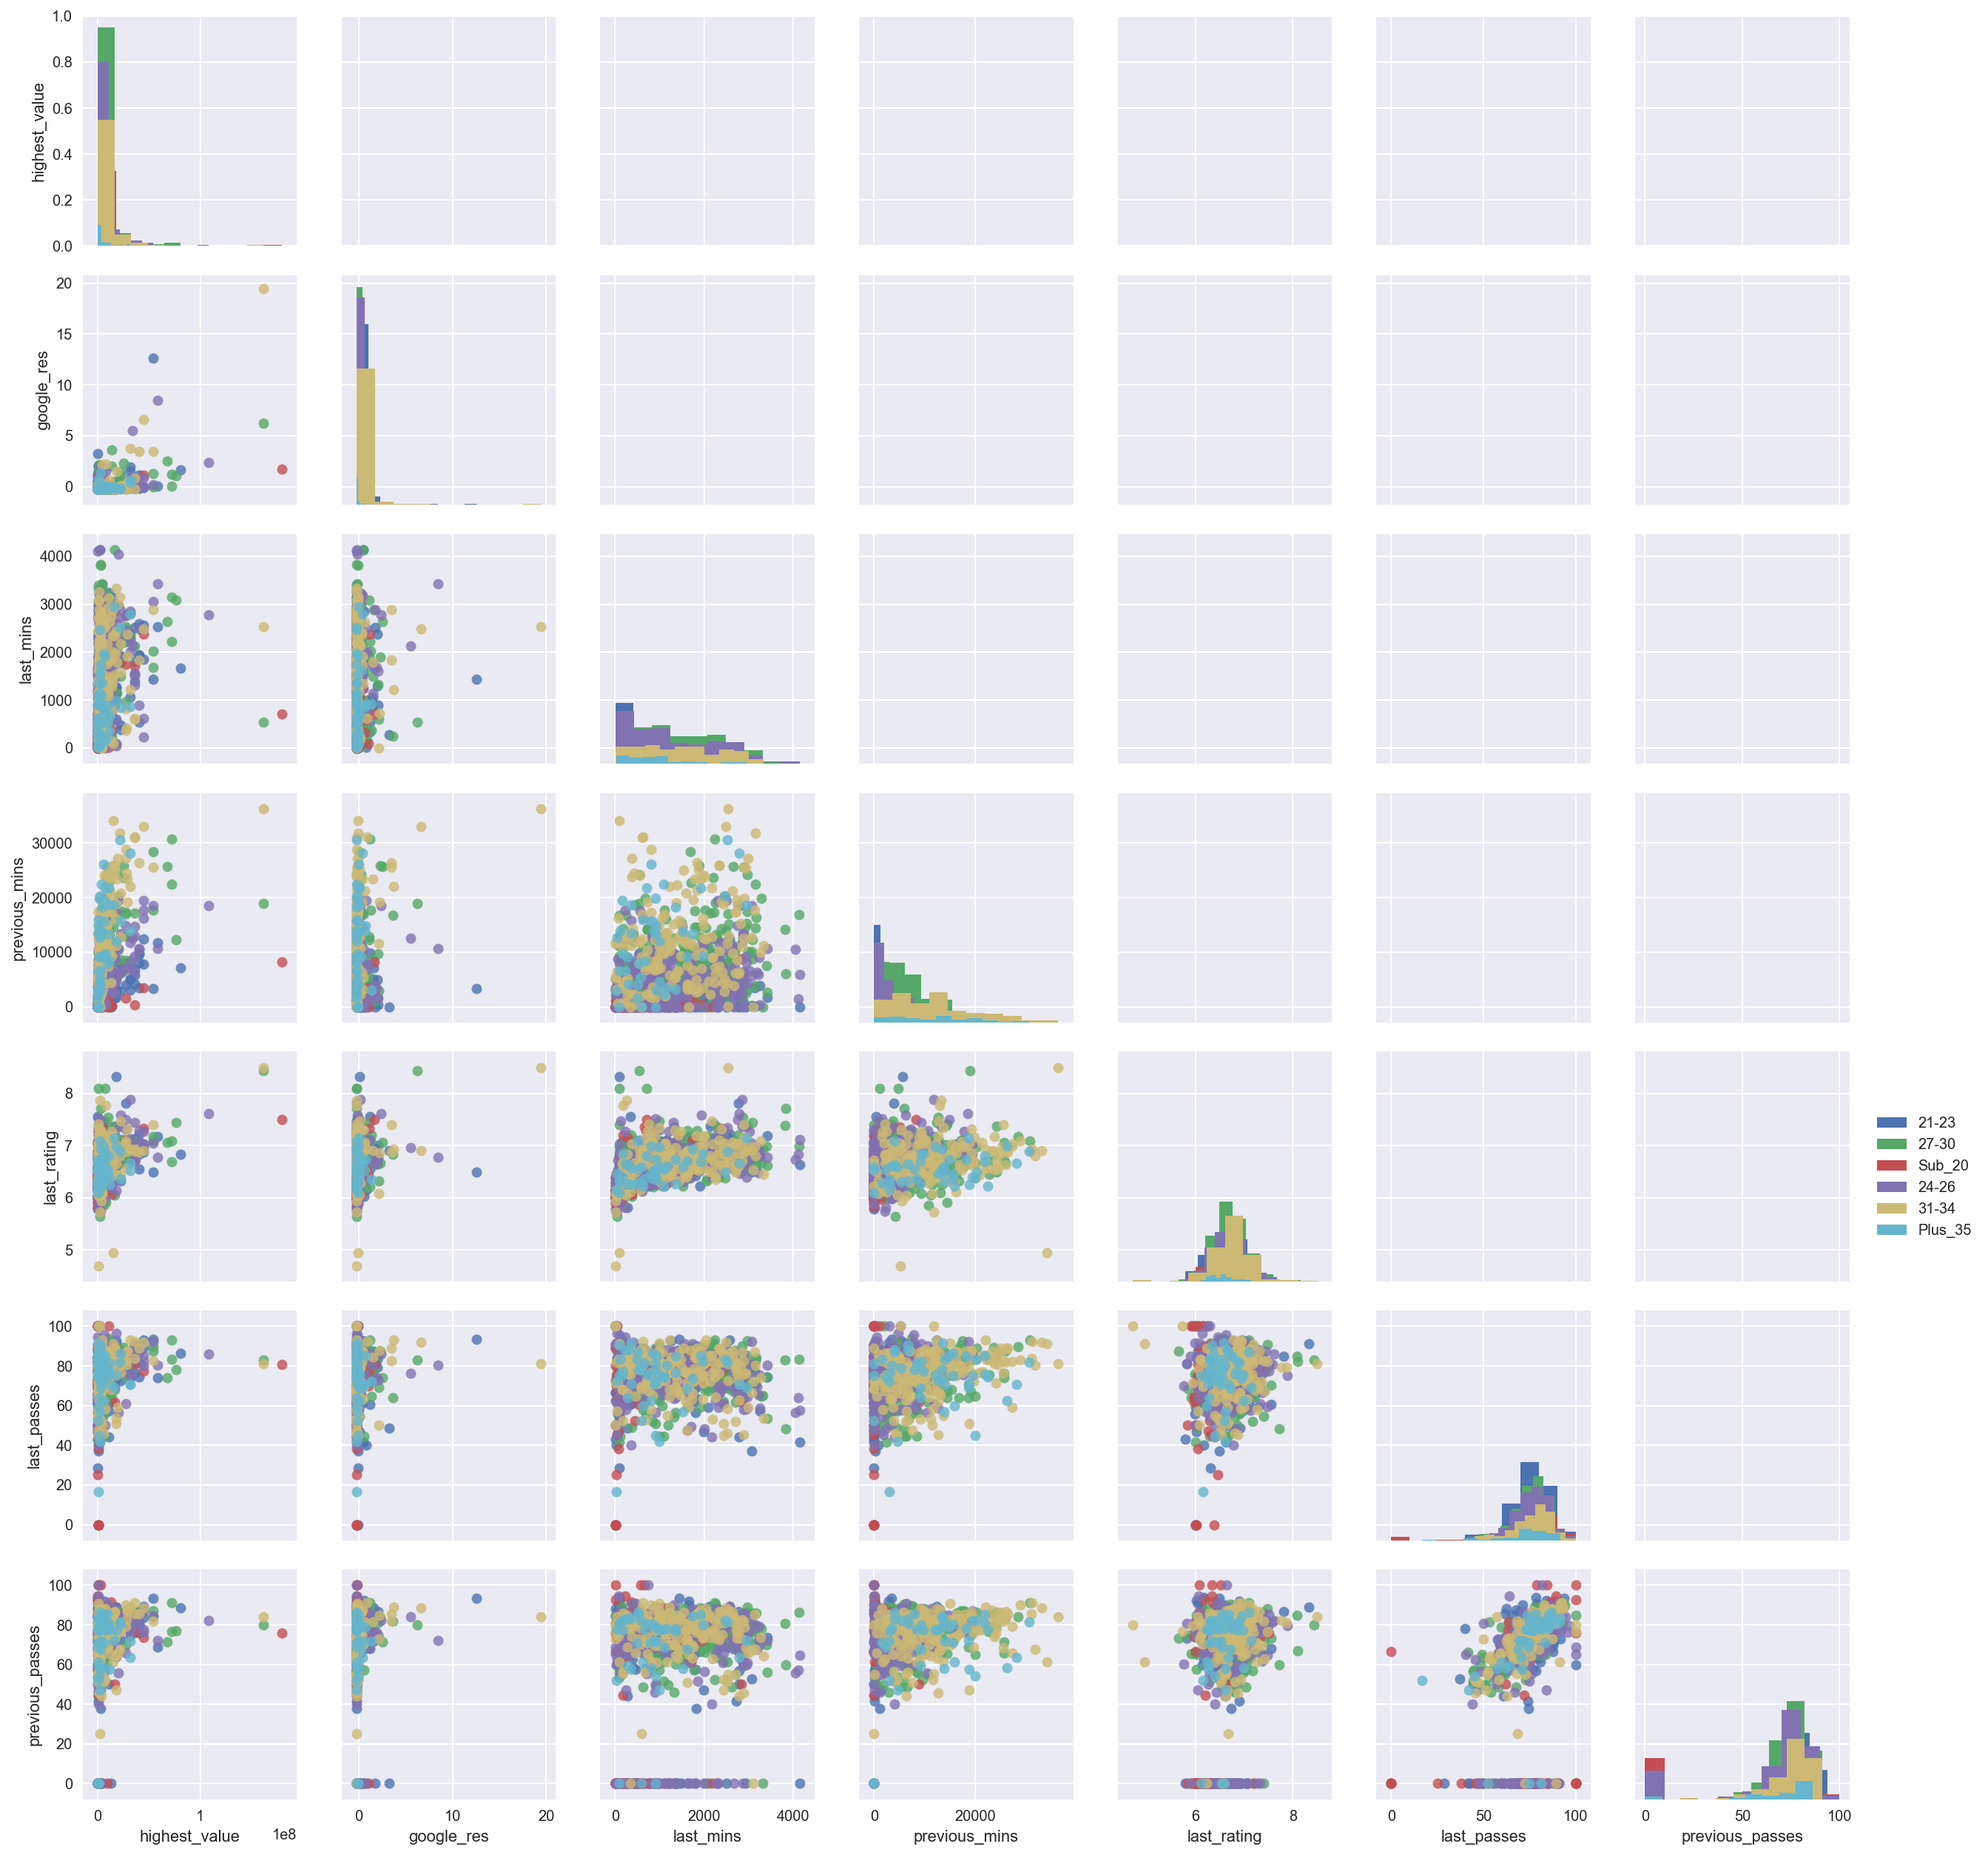

In [1434]:
g = sns.PairGrid(final_w_important[['highest_value','google_res', 'last_mins',
       'previous_mins', 'last_rating', 'last_passes', 'previous_passes','age_group']],hue='age_group',height=2.5)

g = g.map_lower(sns.regplot, fit_reg=False) 
g = g.map_diag(plt.hist)

plt.legend(bbox_to_anchor=(1.1, 3), loc=2, borderaxespad=0.)
plt.show()

## Highest value analysis

#### Variance on highest_value

In [1410]:
highest_value = final_with_preds.highest_value / 100

As we saw before, the highest value of their career is the most important feature of my dataset by far, but it's also the one with the highest variance. Let's go deep into that, to understand how is it impacting the predictions.

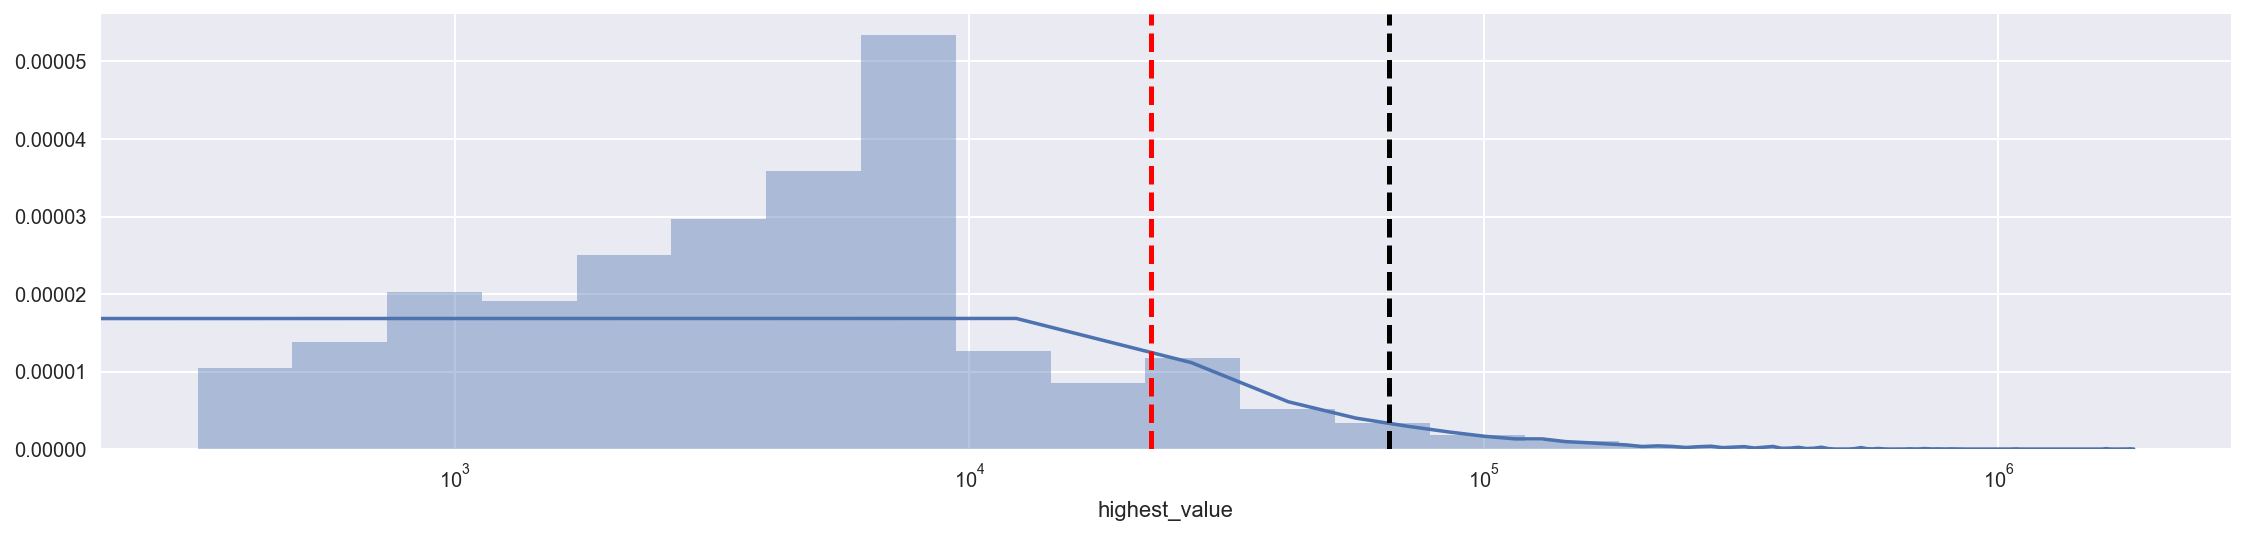

In [1412]:
fig, ax = plt.subplots(figsize=(17,4))
highest_mean = np.mean(highest_value)
highest_median = np.median(highest_value)
sns.distplot(highest_value,bins=np.logspace(2.5,6,20), kde=True, ax=ax);
ax.axvline(highest_mean, lw=2.5, ls='dashed', color='black')
ax.axvline(highest_median, lw=2.5, ls='dashed', color='red')
plt.xscale('log')
plt.show()

This chart shows us indeed, that this feature has massive right skewed distribution, with a mean far to the right of the median, and a long tail, even setting a logarithmic scale. Doing some bootstrap on it's variance, should show us that's really hard to achieve a normal distribution:

In [655]:
def bootstrap(sample, stat_func, iterations=1000):

    boots = []

    for i in range(iterations):
        random_sample = np.random.choice(sample, replace=True, size=len(sample))
        stat = stat_func(random_sample)
        boots.append(stat)

    return boots

In [727]:
std_boot_1 = bootstrap(highest_value, np.std, iterations=100)
std_boot_2 = bootstrap(highest_value, np.std, iterations=500)
std_boot_3 = bootstrap(highest_value, np.std, iterations=2500)
std_boot_4 = bootstrap(highest_value, np.std, iterations=5000)

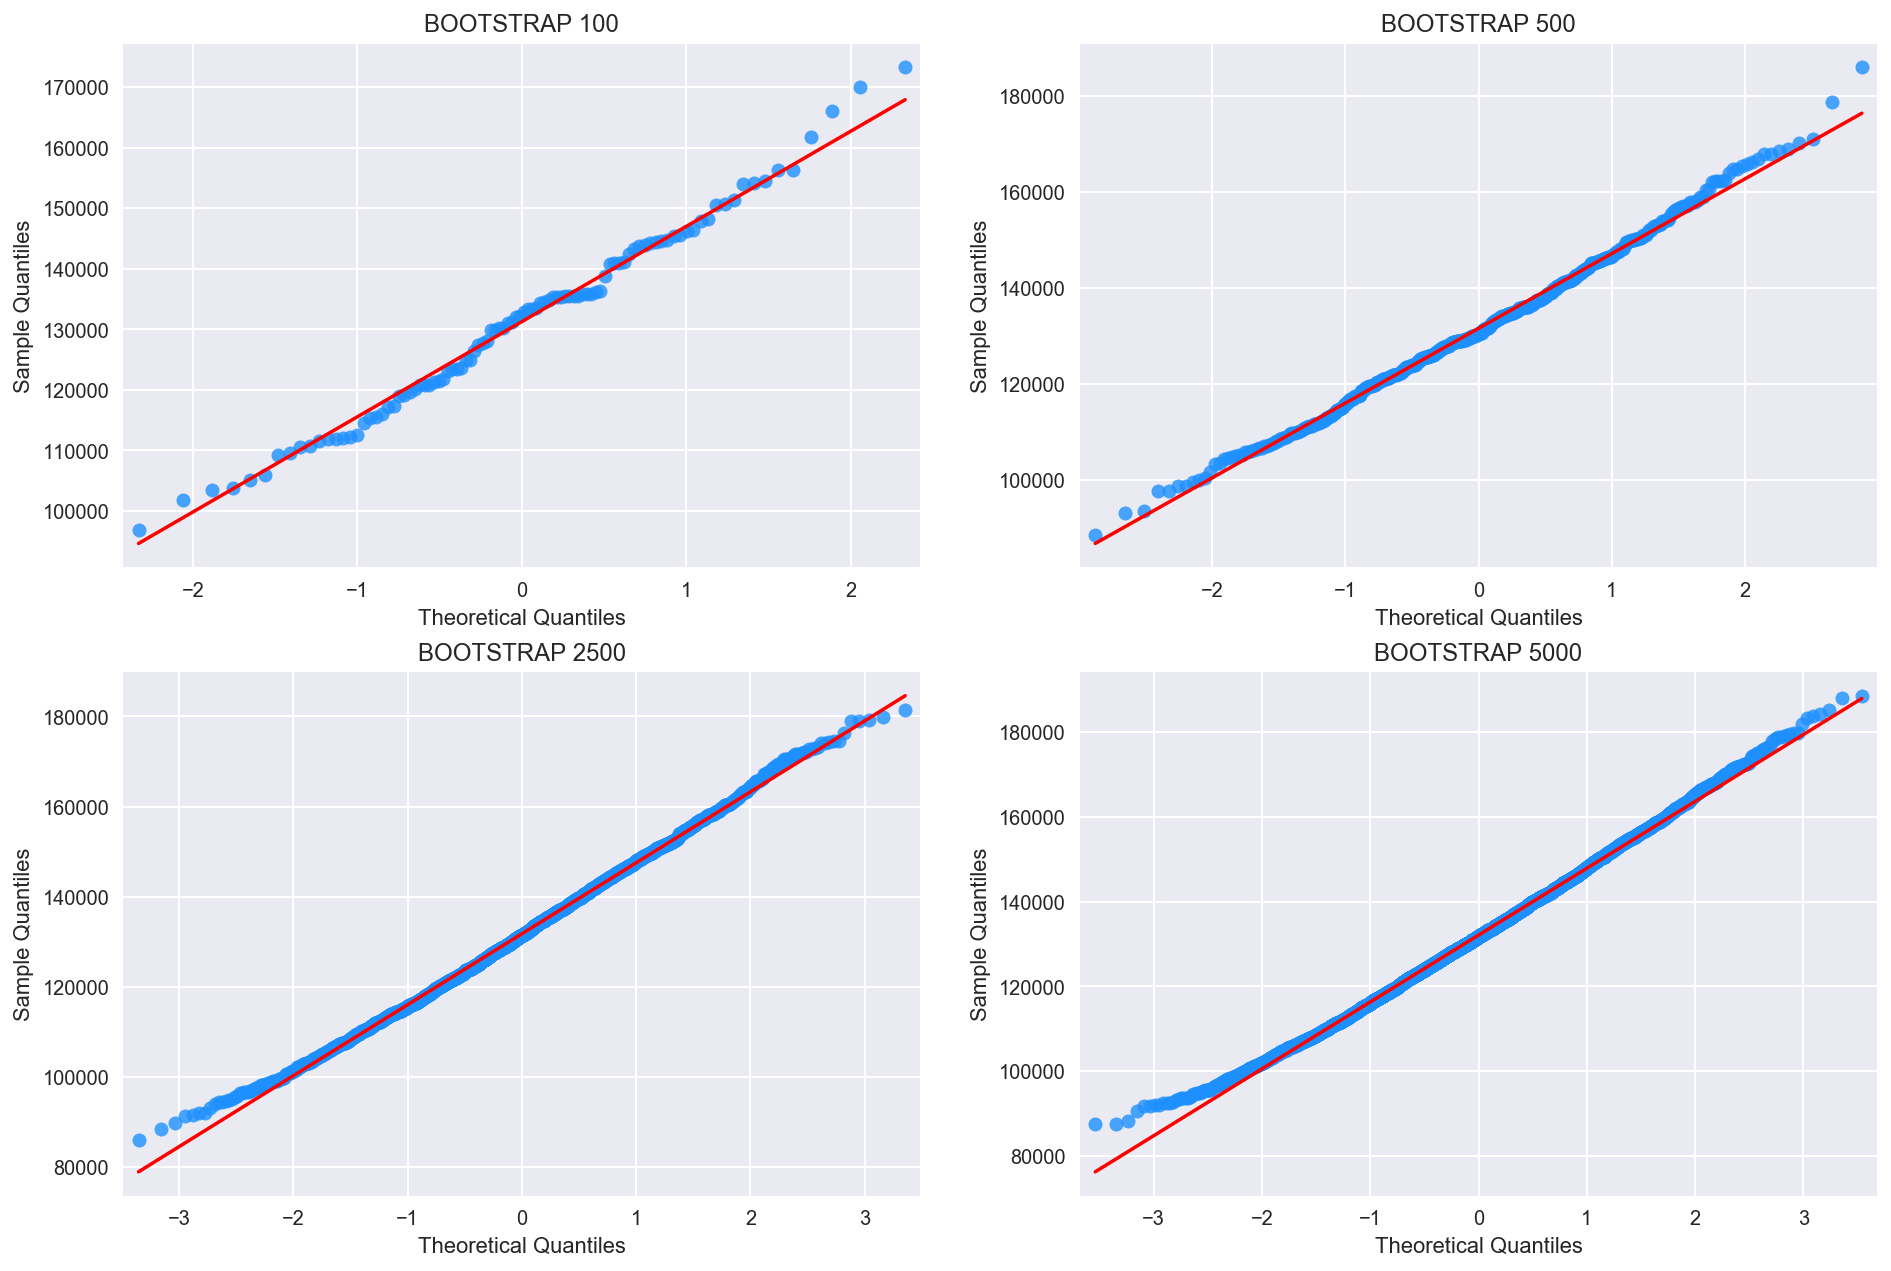

In [939]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(14,8))
axone = qqplot(np.array(std_boot_1), line='s', ax=ax[0,0],c='dodgerblue', alpha=0.8);
axtwo = qqplot(np.array(std_boot_2), line='s',ax=ax[0,1],c='dodgerblue', alpha=0.8);
axthree = qqplot(np.array(std_boot_3), line='s',ax=ax[1,0],c='dodgerblue', alpha=0.8);
axthree = qqplot(np.array(std_boot_4), line='s',ax=ax[1,1],c='dodgerblue', alpha=0.8);

plt.subplots_adjust(bottom=2,top=3)
ax[0,0].set_title('BOOTSTRAP 100');
ax[0,1].set_title('BOOTSTRAP 500');
ax[1,0].set_title('BOOTSTRAP 2500');
ax[1,1].set_title('BOOTSTRAP 5000');

#### But how is it impacting our predictions?

In [78]:
# Creating dataset to plot
value_versus_highest = final_with_preds[['Value','player','highest_value']]

# Plotting
value_versus_highest.iplot(
    y='highest_value', x='player',kind='bar', secondary_y = 'Value',
    secondary_y_title='Current Value', yTitle='Highest Value',
    title='Highest Value vs Current Value',colors=['pink','blue'])

The previous plot doesn't say much, but if we zoom in, we can see that in general we're not missing most of the players value by much. However, we have some players were the difference is a lot. Let's check that in deep.

In [84]:
# In the following lines we'll be creating a few datasets to analyze precisely where are we missing
# comparing players the highest value of each player's career, with their current value and our predicted value

value_versus_highest = final_with_preds[['Value','player','highest_value']]

In [85]:
value_versus_highest['cat'] = ['In_shape' if x==y else 'Old_times_good_times' \
                               for x,y in zip(value_versus_highest.Value,value_versus_highest.highest_value)]

value_versus_highest['Real_dif_preds'] = final_with_preds['Real_dif_preds']

# We are introducing here a new variable, that's the proportional difference in predictions
# This feature is just the absolute value of our difference in predictions (predictions-current value)
# over the current value of each player.

value_versus_highest['prop'] = np.abs(final_with_preds.Real_dif_preds) / final_with_preds.Value

In [86]:
in_shape_old_times_ = value_versus_highest.groupby('cat').mean()
in_shape_old_times_.reset_index(inplace=True)

In [87]:
in_shape_old_times_ = value_versus_highest.groupby('cat').mean()
in_shape_old_times_.reset_index(inplace=True)
in_shape_old_times_['count'] = value_versus_highest.cat.value_counts().values

In [88]:
trace = go.Scatter(
    x = in_shape_old_times_.highest_value,
    y = in_shape_old_times_.Value,
    mode = 'markers',
    text=['In Shape', 'The Good Old Days'],
    marker = dict(
        color = in_shape_old_times_.prop,
        size =  list(in_shape_old_times_['count']),
        sizemode = 'area',
        sizeref =  max(list(in_shape_old_times_['count'])),
        sizemin = 30,
        showscale = True,
    )
)

data=[trace]

layout = go.Layout(
    title = 'Value comparison versus predictions - colors according to difference in predictions',
    xaxis = dict(
        title='Highest Value',
        range = [min(in_shape_old_times_.highest_value)/1.2,max(in_shape_old_times_.highest_value)*1.2]
    ),
    yaxis = dict(
        title='Current Value',
        range = [min(in_shape_old_times_.Value)/1.5,max(in_shape_old_times_.Value)*1.2]
    ),
    annotations=[dict(x=5869000,y=3250000,xref='x',yref='y',text='The Good Old Days',showarrow=True,arrowhead=7,ax=0,ay=-40),
                dict(x=7288000,y=7388000,xref='x',yref='y',text='In Shape',showarrow=True,arrowhead=7,ax=0,ay=-40)]
  )

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

This chart shows a couple of things: 

1) We have approx. the same number of players in shape versus those who have lost value. 

2) Since our most important feature is the highest value of each player, it's logical that our model is being very accurate with those players that are right now at their highest value.

Let's check the role of the outliers.

#### Analyzing the presence of outliers

In [89]:
first = go.Box(
    y = value_versus_highest.highest_value[value_versus_highest.cat=='In_shape'],
    name = "HIGHEST value for in shape players",
    boxpoints = 'outliers',
    marker = dict(
        color = 'rgb(214, 12, 140)')
)

second = go.Box(
    y = value_versus_highest.Value[value_versus_highest.cat=='In_shape'],
    name = "CURRENT value for in shape players",
    boxpoints = 'outliers',
    marker = dict(
        color = 'rgb(214, 12, 140)')
)


third = go.Box(
    y = value_versus_highest.highest_value[value_versus_highest.cat=='Old_times_good_times'],
    name = "HIGHEST value for depreciated players",
    boxpoints = 'outliers',
    marker = dict(
        color = 'rgba(44, 160, 101, 0.5)')
)

fourth = go.Box(
    y = value_versus_highest.Value[value_versus_highest.cat=='Old_times_good_times'],
    name = 'CURRENT value for depreciated players',
    boxpoints = 'outliers',
    marker = dict(
        color = 'rgba(44, 160, 101, 0.5)')
)

data = [first, second, third, fourth]

layout = go.Layout(
    title = "Box Plot Styling Outliers",
)

fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

As we can see, even though we have outliers in both groups, for those players in shape there seems to be a higher amount of unusually expensive players. So we’ll need to individualize outliers and non_outliers, to get to any conclusion.

In [90]:
# Setting up the lower and upper fence to identify outliers

i_range = np.percentile(value_versus_highest.Value, 75)-np.percentile(value_versus_highest.Value, 25)
lower_fence = i_range - (1.5*np.percentile(value_versus_highest.Value, 25))
upper_fence = i_range + (1.5*np.percentile(value_versus_highest.Value, 75))

In [91]:
# Creating column to validate if it's an outlier

value_versus_highest['is_outlier'] = ['Outlier' if x>upper_fence else 'Non_Outlier' \
                                      for x in value_versus_highest.Value]

In [92]:
# Filtering by outliers
in_shape_old_times_outliers = value_versus_highest[value_versus_highest.is_outlier=='Outlier'].groupby('cat').mean()
in_shape_old_times_outliers.reset_index(inplace=True)
in_shape_old_times_outliers['count'] = value_versus_highest.cat[value_versus_highest.is_outlier=='Outlier'].value_counts().values

# Filtering by non outliers
in_shape_old_times_non_outliers = value_versus_highest[value_versus_highest.is_outlier=='Non_Outlier'].groupby('cat').mean()
in_shape_old_times_non_outliers.reset_index(inplace=True)
in_shape_old_times_non_outliers['count'] = value_versus_highest.cat[value_versus_highest.is_outlier=='Non_Outlier'].value_counts().values

In [93]:
trace_out = go.Scatter(
    x = in_shape_old_times_outliers.highest_value,
    y = in_shape_old_times_outliers.Value,
    mode = 'markers',
    text=['In Shape', 'The Good Old Days'],
    marker = dict(
        color = in_shape_old_times_outliers.prop,
        size =  list(in_shape_old_times_outliers['count']),
        sizemode = 'area',
        #sizeref =  max(list(in_shape_old_times_outliers['count'])),
        #sizemin = min(in_shape_old_times_outliers['count']),
        showscale = True,
    )
)

trace_non = go.Scatter(
    x = in_shape_old_times_non_outliers.highest_value,
    y = in_shape_old_times_non_outliers.Value,
    mode = 'markers',
    text=['In Shape', 'The Good Old Days'],
    marker = dict(
        color = in_shape_old_times_non_outliers.prop,
        size =  list(in_shape_old_times_non_outliers['count']),
        sizemode = 'area',
        #sizeref =  max(list(in_shape_old_times_non_outliers['count'])),
        #sizemin = min(in_shape_old_times_non_outliers['count']),
        showscale = True,
    )
)


fig = tools.make_subplots(rows=1, cols=2)
fig.append_trace(trace_out, 1, 1)
fig.append_trace(trace_non, 1, 2)
fig['layout']['xaxis1'].update(title='Highest value for outliers', range=[30000000, 34000000])
fig['layout']['yaxis1'].update(title='Current value for outliers', range=[22000000, 34000000])
fig['layout']['xaxis2'].update(title='Highest valuue for NON outliers', range=[2000000, 5000000])
fig['layout']['yaxis2'].update(title='Current valuue for NON outliers', range=[0, 5000000])
fig['layout'].update(showlegend=False, height=500, width=1000, title='Comparing outliers versus non outliers')

py.iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [2516]:
in_shape_old_times_outliers

,cat,Value,highest_value,Real_dif_preds,prop,count
0,In_shape,3.166685e+07,3.166685e+07,4.422139e+06,0.114967,89
1,Old_times_good_times,2.537027e+07,3.281351e+07,1.757803e+06,0.126124,37


In [2517]:
in_shape_old_times_non_outliers

,cat,Value,highest_value,Real_dif_preds,prop,count
0,In_shape,2.434971e+06,2.434971e+06,412120.120805,0.152588,570
1,Old_times_good_times,1.709093e+06,4.120170e+06,-131285.219298,0.401860,447


In [2518]:
in_shape_old_times_con = pd.concat([in_shape_old_times_non_outliers,in_shape_old_times_outliers],axis=0)

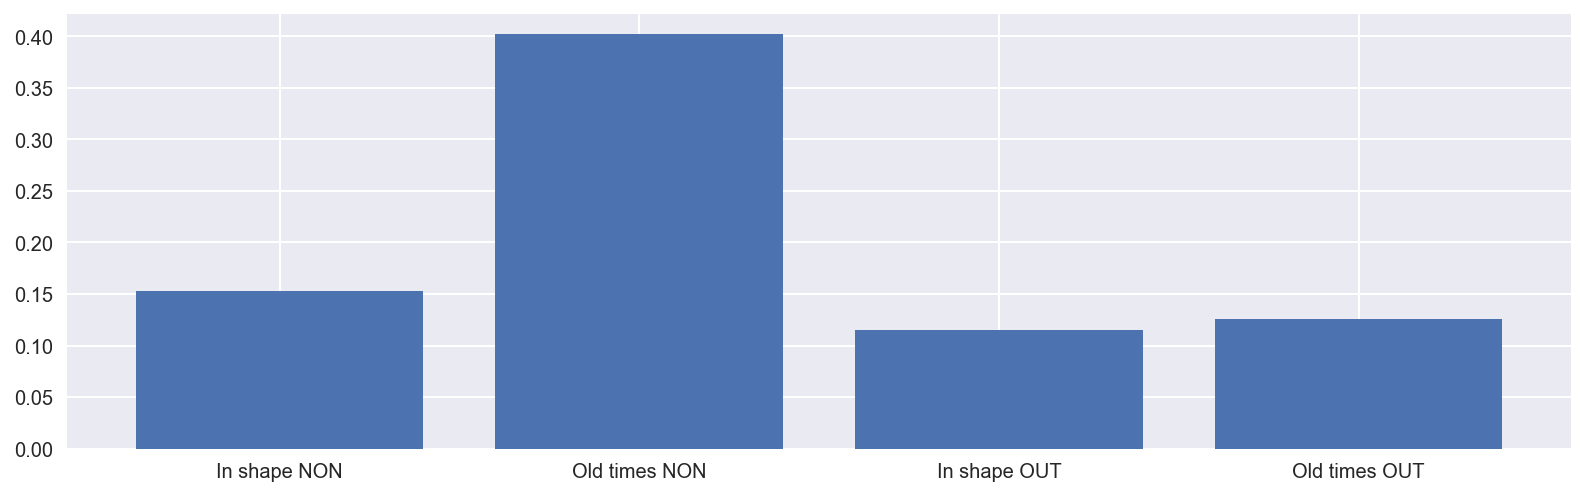

In [2519]:
fig, ax = plt.subplots(figsize=(12,4))

plt.bar(x=['In shape NON','Old times NON','In shape OUT','Old times OUT'],
        height=np.abs(in_shape_old_times_con.prop));

plt.show()

Don’t let you fool by the absolute difference in predictions (as it happened to me), since it’s because the average value of each group. When we see the difference in proportion with the current value, we can see that we are predicting very bad the group of non outliers which are not in shape (i.e., they are not right now at their highest value). So we can say we don’t have a big outliers situation.

In [94]:
# We are introducing here the proportional value loss
# This feature is just the absolute number for the value each player lost during his career
# over their current value.
# In other words, this feature could be seen as how many times a player lost his current value throughout his career.

worst_preds = value_versus_highest[(value_versus_highest.cat == 'Old_times_good_times') & (value_versus_highest.is_outlier == 'Non_Outlier')]
worst_preds['value_loss'] = worst_preds.highest_value - worst_preds.Value
worst_preds['prop_value_loss'] = worst_preds.value_loss / worst_preds.Value
worst_preds.sort_values(by='prop',ascending=False,inplace=True)

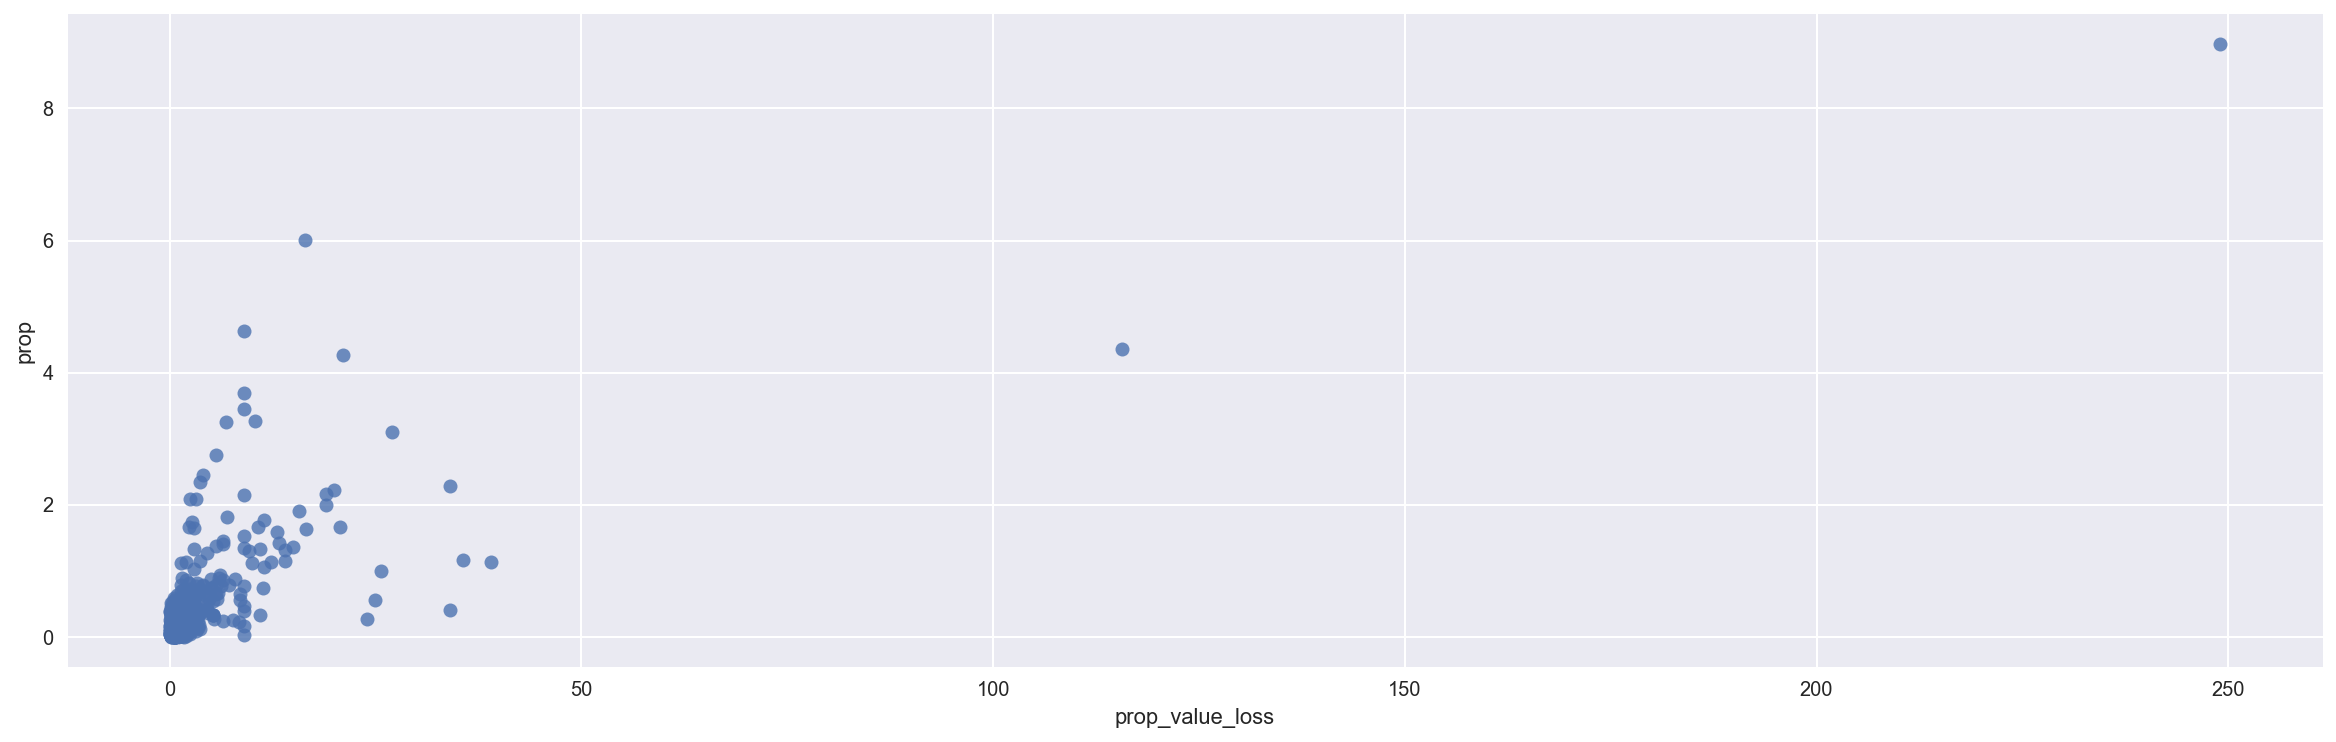

In [2632]:
fig, ax = plt.subplots(figsize=(18,6))
sns.regplot(x=worst_preds.prop_value_loss, y=worst_preds.prop,fit_reg=False)
plt.show()

**The question here is: How are these guys impoverishing our predictions?**

In [2540]:
mean_difference = []
for i in range(1,int(worst_preds.prop_value_loss.max())+1):
    mean_difference.append(worst_preds.prop[worst_preds.prop_value_loss < i].mean())

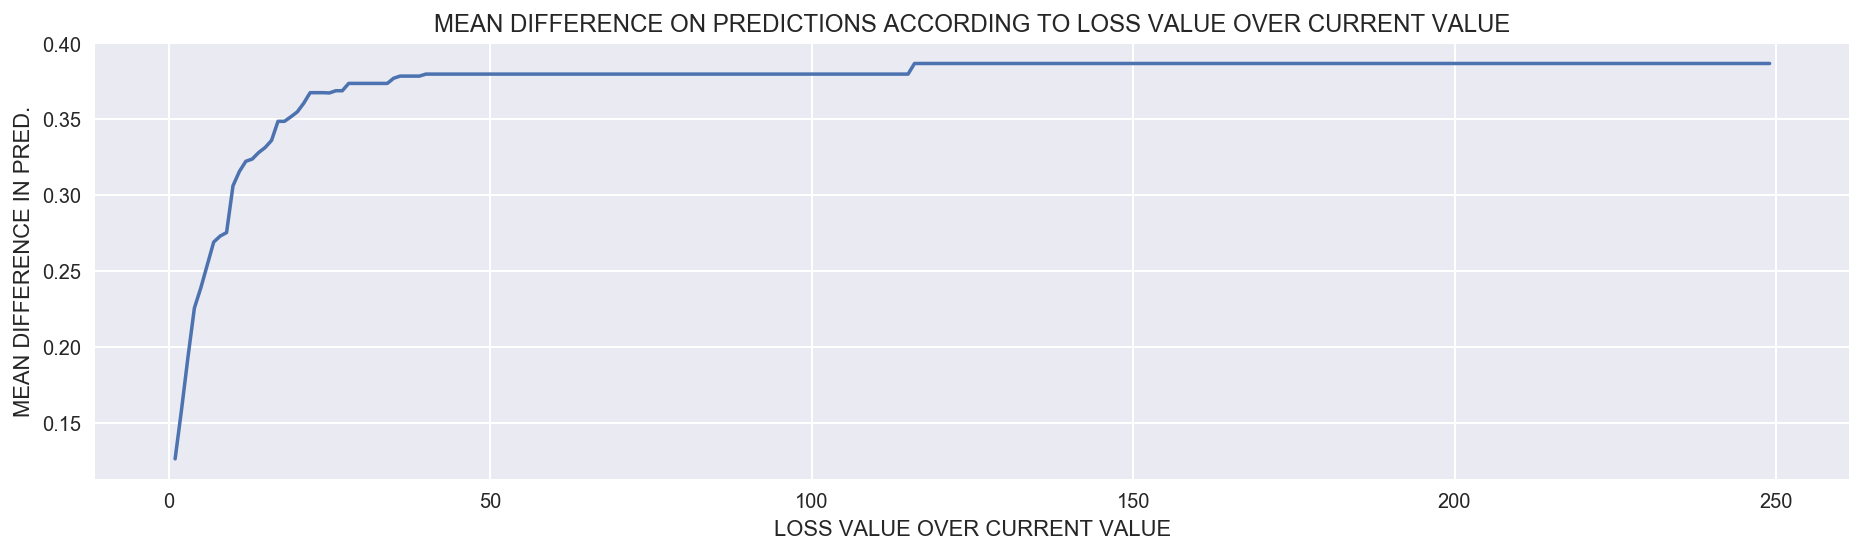

In [2545]:
fix, ax = plt.subplots(figsize=(14,4))
sns.lineplot(x=range(1,int(worst_preds.prop_value_loss.max())+1), y=mean_difference);
ax.set_title('MEAN DIFFERENCE ON PREDICTIONS ACCORDING TO LOSS VALUE OVER CURRENT VALUE')

ax.set_ylabel('MEAN DIFFERENCE IN PRED.')    
ax.set_xlabel('LOSS VALUE OVER CURRENT VALUE')
plt.show()

We can easily see here that our mean difference in predictions only gets higher and higher when we add players with a higher proportional value loss.

#### Trying to predict residuals for outliers

In [79]:
# Merging and dropping duplicates

final_with_clubs = final_with_clubs.merge(final_with_preds[['player_link_tm','Value','Pred_Value','Real_dif_preds']], on='player_link_tm')

final_with_clubs.drop_duplicates(subset=['player_link_tm'],inplace=True)

In [80]:
# Pulling apart the links in case I need to merge de data again post modeling

final_link_ws = final_with_clubs.pop('player_link_ws')
final_link_tm = final_with_clubs.pop('player_link_tm')

In [96]:
# Dropping columns and indicating which observations are outliers

#final_with_clubs.drop(['player','lastname','position','nationality','search',
#                       'last_team_x','last_season'], axis=1, inplace=True)

dum_final_with_clubs = pd.get_dummies(final_with_clubs, drop_first=True)

dum_final_with_clubs['in_shape'] = dum_final_with_clubs.Value==dum_final_with_clubs.highest_value
dum_final_with_clubs['outlier'] = dum_final_with_clubs.Value > upper_fence

In [97]:
# Dropping the highest value
dum_final_with_clubs.drop('highest_value',axis=1,inplace=True)

In [98]:
# Creating the predictor dataset with only outliers

predictor_in_shape = dum_final_with_clubs[(dum_final_with_clubs.in_shape == True)]
predictor_not_in_shape = dum_final_with_clubs[(dum_final_with_clubs.in_shape == False) & (dum_final_with_clubs.outlier == False)]

In [99]:
# Making a copy of the dataset without the highest differences
filtered_predictor_not_in_shape = predictor_not_in_shape.copy()
filtered_predictor_not_in_shape['abs_real_dif'] = np.abs(filtered_predictor_not_in_shape.Real_dif_preds)
filtered_predictor_not_in_shape = filtered_predictor_not_in_shape[filtered_predictor_not_in_shape.Real_dif_preds < np.percentile(filtered_predictor_not_in_shape.Real_dif_preds,80)]

In [100]:
# Pulling apart the target and dropping some extra columns

filtered_target = filtered_predictor_not_in_shape.pop('Real_dif_preds')
target_in_shape = predictor_in_shape.pop('Real_dif_preds')
target_not_in_shape = predictor_not_in_shape.pop('Real_dif_preds')

In [101]:
filtered_predictor_not_in_shape.drop(['abs_real_dif','current_log','double_trans','Value','Pred_Value','in_shape'], axis=1, inplace=True)
predictor_in_shape.drop(['current_log','double_trans','Value','Pred_Value','in_shape'], axis=1, inplace=True)
predictor_not_in_shape.drop(['current_log','double_trans','Value','Pred_Value','in_shape'], axis=1, inplace=True)

##### Residuals for players in shape

In [2558]:
X_train, X_test, y_train, y_test = train_test_split(
predictor_in_shape, target_in_shape, test_size = 0.40, random_state=123)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
predictor_in_shape_std = scaler.transform(predictor_in_shape)

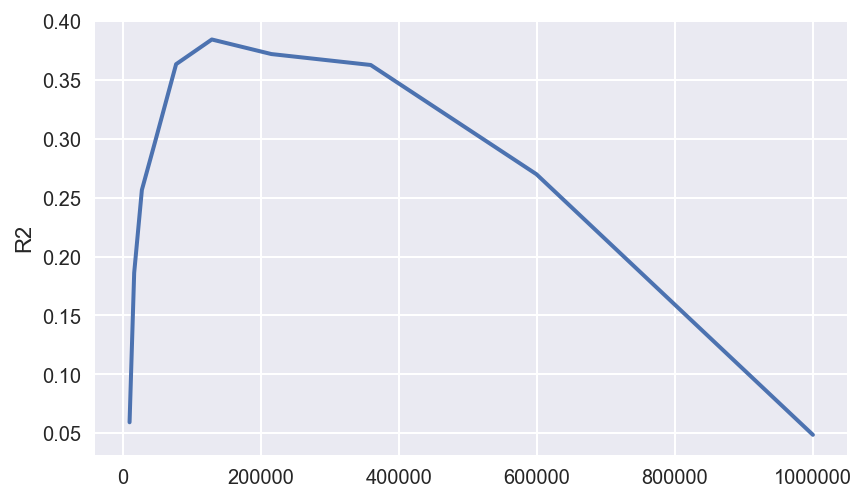

In [2614]:
alpha_values = np.logspace(4,6,10)
scores = alpha_scores(Lasso, alpha_values, X_train, y_train)

plt.plot(alpha_values, [score for score in scores], lw=2)
plt.ylabel('R2')
plt.show()

In [2566]:
model_lasso = LassoCV(alphas=np.logspace(4,6,20), cv=5)

model_lasso.fit(X_train, y_train)

print('Best alpha:', model_lasso.alpha_)

print('Training score:', model_lasso.score(X_train, y_train))

print('Test score:', model_lasso.score(X_test, y_test))

scores = cross_val_score(model_lasso, X_train, y_train, cv=5)
print('Mean cross-validated training score:', scores.mean())

Best alpha: 69519.27961775605
Training score: 0.8630195604265783
Test score: 0.2755212575888496
Mean cross-validated training score: 0.37154143192386246


In [2606]:
in_shape_coef = pd.DataFrame(model_lasso.coef_,columns=['coef'],index=predictor_in_shape.columns)

In [2646]:
in_shape_coef.sort_values(by='coef',ascending=False).head(5)

,coef
team_Barcelona,443343.166876
Continental Nat Winner,332025.375447
team_ManCity,316214.847878
nat_team_min_pond,314092.724450
Continental Club Runner-up,272412.090287


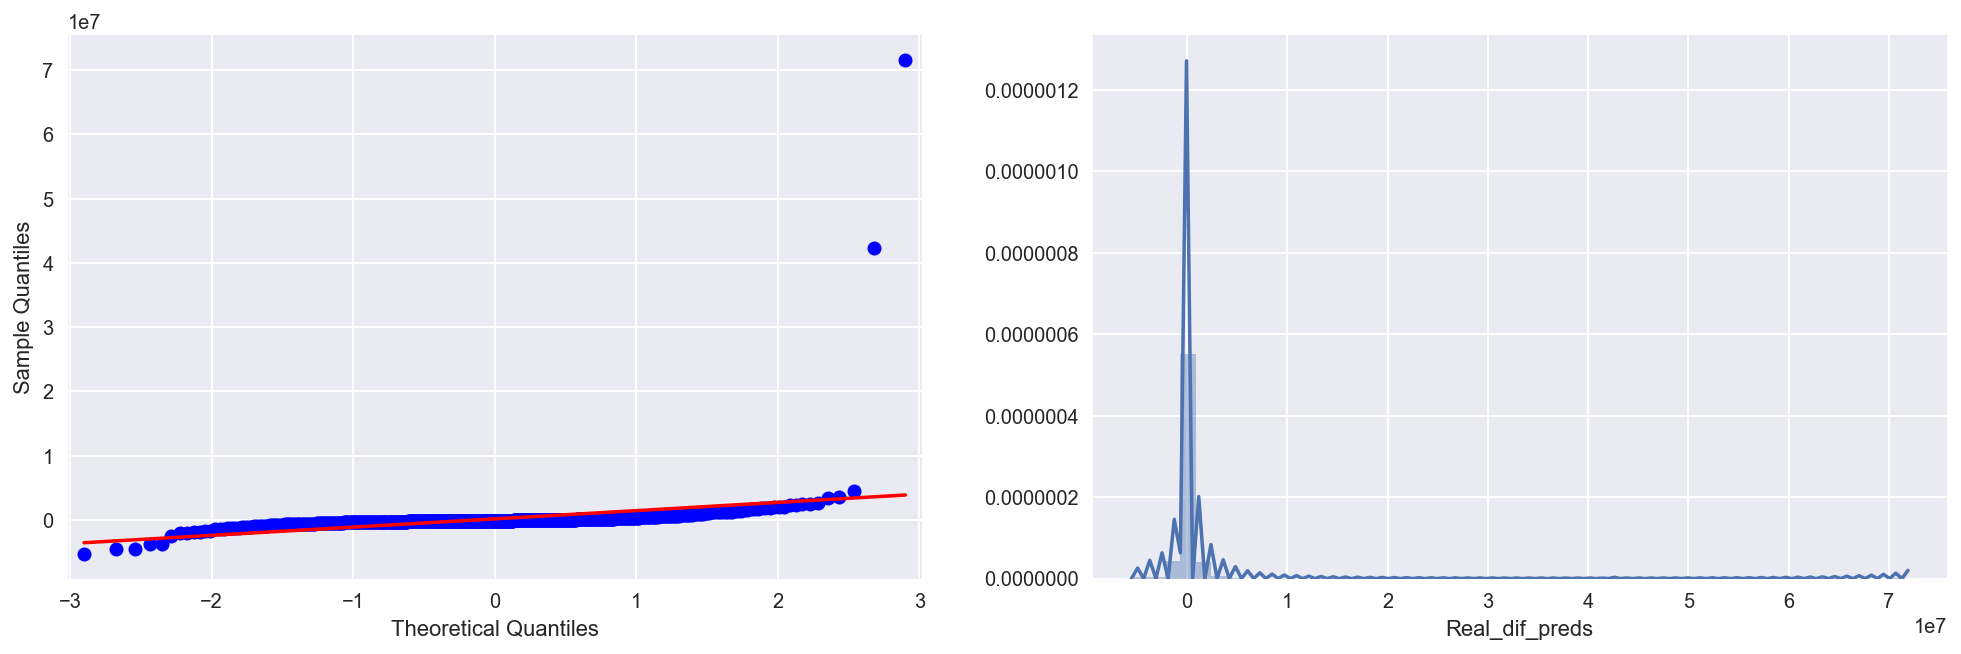

In [2608]:
lasso_in_shape_pred = model_lasso.predict(predictor_in_shape_std)
lasso_in_shape_res = target_in_shape - lasso_in_shape_pred
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
qqplot(lasso_in_shape_res, line='r', ax=ax[0]);
sns.distplot(lasso_in_shape_res, ax=ax[1]);
plt.show()

We can see in here that with some reasonable distribution of residuals, we can approach at least a little to predict the residuals of our original model for the players in shape. 

And the most interesting part out of here, is that he have now a completely different set of variables in our feature importance analysis. Features that previously were been dropped by the regularization. This means that we actually have features with predicting power for this dataset.

##### Players not in shape not outliers: our worst predictions

In [2609]:
X_train_not, X_test_not, y_train_not, y_test_not = train_test_split(
predictor_not_in_shape, target_not_in_shape, test_size = 0.50, random_state=123)

scaler_ = StandardScaler()
X_train_not = scaler.fit_transform(X_train_not)
X_test_not = scaler.transform(X_test_not)
predictor_not_in_shape_std = scaler.transform(predictor_not_in_shape)

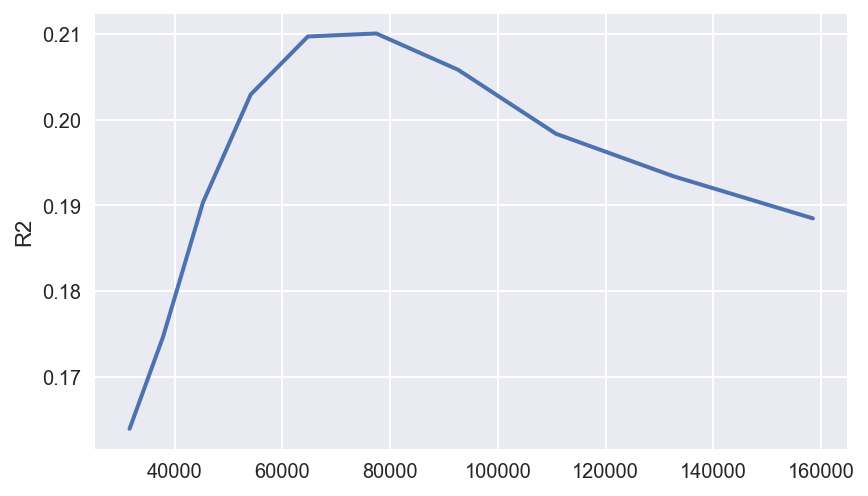

In [2575]:
alpha_values = np.logspace(4.5,5.2,10)
scores = alpha_scores(Lasso, alpha_values, X_train_not, y_train_not)

plt.plot(alpha_values, [score for score in scores], lw=2)
plt.ylabel('R2')
plt.show()

In [2576]:
model_lasso_not = LassoCV(alphas=np.logspace(4.5,5.2,20), cv=5)

model_lasso_not.fit(X_train_not, y_train_not)

print('Best alpha:', model_lasso_not.alpha_)

print('Training score:', model_lasso_not.score(X_train_not, y_train_not))

print('Test score:', model_lasso_not.score(X_test_not, y_test_not))

scores = cross_val_score(model_lasso_not, X_train_not, y_train_not, cv=5)
print('Mean cross-validated training score:', scores.mean())

Best alpha: 67854.54573393583
Training score: 0.6979285752717461
Test score: -0.3460158206644939
Mean cross-validated training score: 0.16479832819344736


In [2610]:
# Trying again, but this time filtering players with the highest differences in predictions

X_train_fil, X_test_fil, y_train_fil, y_test_fil = train_test_split(
filtered_predictor_not_in_shape, filtered_target, test_size = 0.50, random_state=123)

scaler_ = StandardScaler()
X_train_fil = scaler.fit_transform(X_train_fil)
X_test_fil = scaler.transform(X_test_fil)
filtered_predictor_not_in_shape_std = scaler.transform(filtered_predictor_not_in_shape)

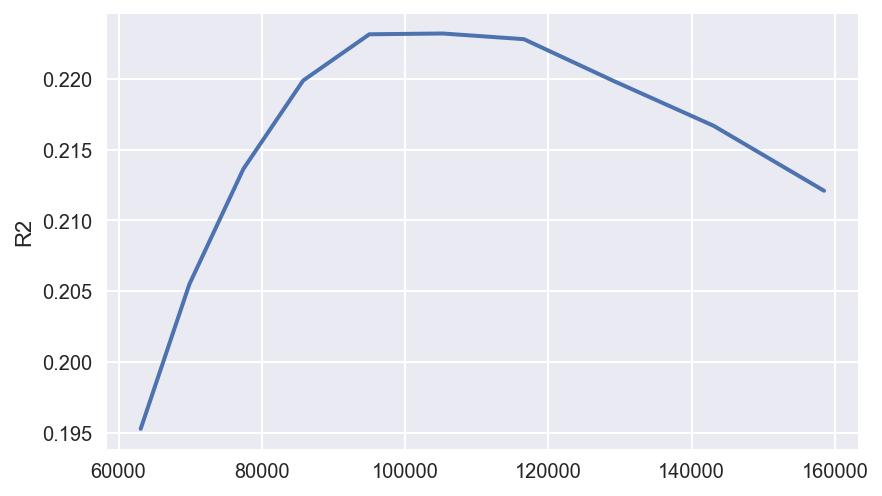

In [2598]:
alpha_values = np.logspace(4.8,5.2,10)
scores = alpha_scores(Lasso, alpha_values, X_train_fil, y_train_fil)

plt.plot(alpha_values, [score for score in scores], lw=2)
plt.ylabel('R2')
plt.show()

In [2599]:
model_lasso_fil = LassoCV(alphas=np.logspace(4.8,5.2,20), cv=5)

model_lasso_fil.fit(X_train_fil, y_train_fil)

print('Best alpha:', model_lasso_fil.alpha_)

print('Training score:', model_lasso_fil.score(X_train_fil, y_train_fil))

print('Test score:', model_lasso_fil.score(X_test_fil, y_test_fil))

scores = cross_val_score(model_lasso_fil, X_train_fil, y_train_fil, cv=5)
print('Mean cross-validated training score:', scores.mean())

Best alpha: 88586.67904100832
Training score: 0.7166741574564153
Test score: 0.23766690941584856
Mean cross-validated training score: 0.21239149908695748


In [2600]:
fil_coef = pd.DataFrame(model_lasso_fil.coef_,columns=['coef'],index=filtered_predictor_not_in_shape.columns)

In [2645]:
fil_coef.sort_values(by='coef',ascending=True).head(5)

,coef
team_Fulham,-361595.125396
nat_team_min_pond,-154790.138091
team_Hoffenheim,-109079.449790
team_Brighton,-92942.766690
total_awards,-90308.748039


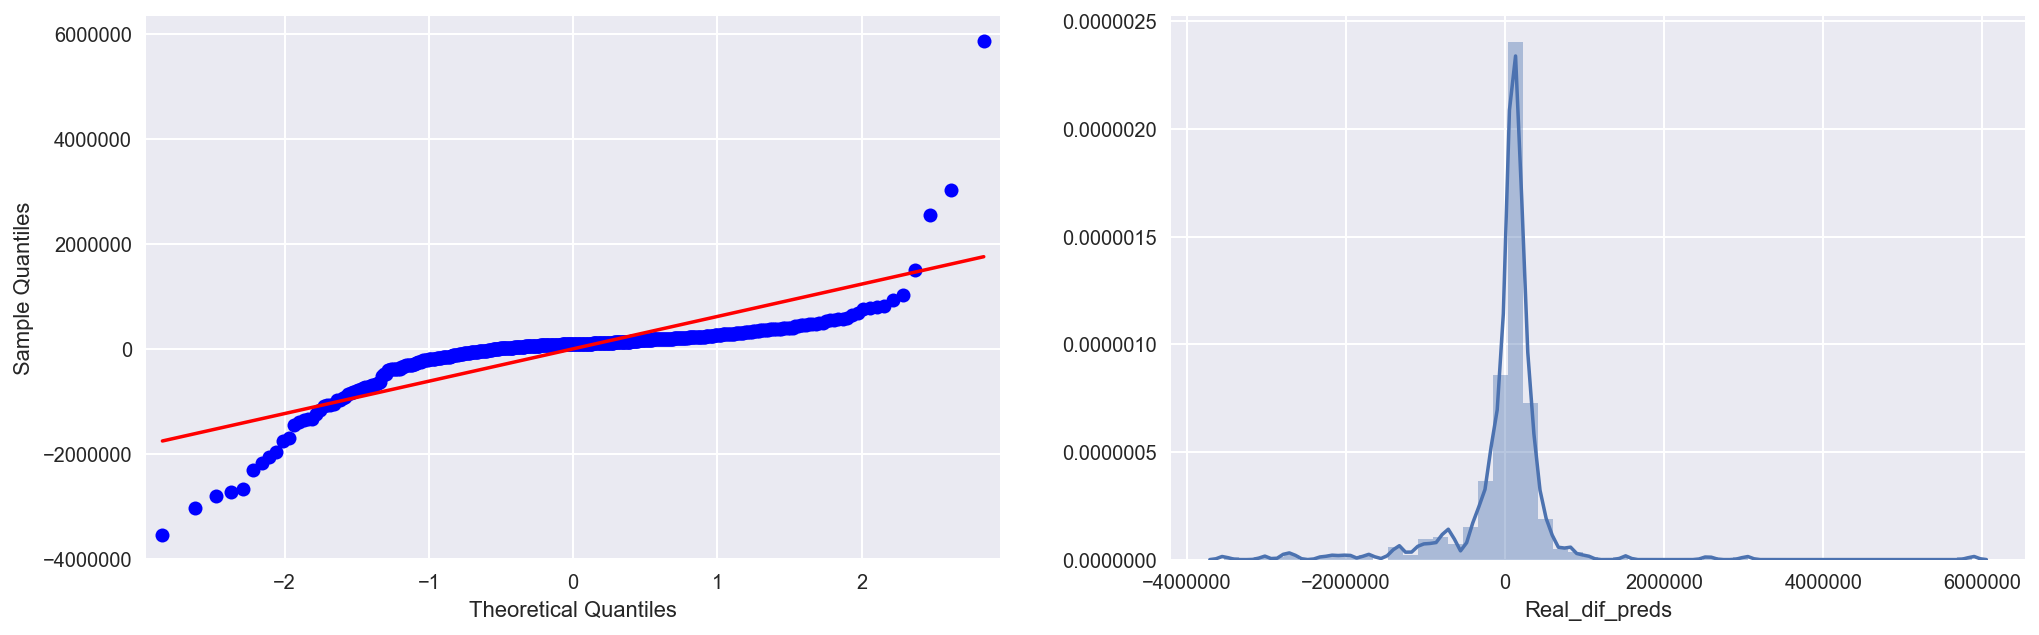

In [2613]:
lasso_not_in_shape_pred = model_lasso_fil.predict(filtered_predictor_not_in_shape_std)
lasso_not_in_shape_res = filtered_target - lasso_not_in_shape_pred
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
qqplot(lasso_not_in_shape_res, line='s', ax=ax[0]);
sns.distplot(lasso_not_in_shape_res, ax=ax[1]);
plt.show()

Is we include all the players we cannot arrive to any conclusion, but if we filter those players for which we were predicting worse, we can arrive to some positive scores, and without having a crazy distribution of residuals, we can check that the feature importance is again completely different, giving us some notion that maybe we also have the necessary features to predict correctly this group of players.

## League analysis

In [2416]:
final_with_preds[final_with_preds.league == 'Super Lig (TUR)'].sort_values(by='Real_dif_preds',ascending=False).head()

,player_link_tm,player,lastname,Log_Value,Pred_Log_Value,Log_dif_preds,Value,Pred_Value,Real_dif_preds,highest_value,...,Olympic medalist,League T2 Runner-up,Second place at the Olympic Games,Third place at the Olympic Games,World Cup participant,World Cup runner-up,World Cup third place,World Cup winner,total_awards,google_res
1048,/edin-visca/profil/spieler/109217,Edin Visca,Visca,16.108045,15.526084,0.581962,9900000.0,5532131.0,4367869.0,9900000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,-0.177018
419,/eljif-elmas/profil/spieler/400489,Eljif Elmas,Elmas,15.725053,15.225495,0.499558,6750000.0,4095893.0,2654107.0,6750000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.193752
427,/jailson/profil/spieler/366948,Jailson,Jailson,14.962913,14.193220,0.769693,3150000.0,1458940.0,1691060.0,3150000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,-0.081956
751,/fedor-kudryashov/profil/spieler/48634,Fedor Kudryashov,Kudryashov,14.739769,14.135943,0.603826,2520000.0,1377723.0,1142277.0,3150000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.238899
864,/tolgay-arslan/profil/spieler/53536,Tolgay Arslan,Arslan,15.033386,14.686653,0.346733,3380000.0,2389639.0,990361.0,6750000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.014388


In [2615]:
final_with_preds['prop'] = np.abs(final_with_preds.Real_dif_preds) / final_with_preds.Value
final_with_preds['value-loss'] = final_with_preds.highest_value - final_with_preds.Value
final_with_preds['prop_value_loss'] = np.abs(final_with_preds['value-loss']) / final_with_preds.Value

In [2617]:
real_vs_value_league = final_with_preds[['Real_dif_preds','Value','league','prop','value-loss','prop_value_loss',
                                         'highest_value']].groupby('league').mean().sort_values(by='Value')


In [2624]:
avg_value = go.Scatter(x=real_vs_value_league.index, y=real_vs_value_league['prop']*5000000, name='Prop diff in pred')
dif_in_pred = go.Scatter(x=real_vs_value_league.index, y=real_vs_value_league['Value'], name='Avg Value')
highest_value = go.Scatter(x=real_vs_value_league.index, y=real_vs_value_league['highest_value'], name='Avg Highest Value')
value_loss = go.Scatter(x=real_vs_value_league.index, y=real_vs_value_league['prop_value_loss']*1000000, name='Prop Value Loss')


data = [avg_value, dif_in_pred, highest_value, value_loss]

layout = go.Layout(
    width = 800,
    height = 400,
    title = "Predictions accuracy by leagues")

fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

Again the proportional value loss squeezing in to mess our predictions. Some leagues that love to buy depreciated players get the worst proportional difference in predictions...Spain’s second division, the Super Lig from Turkey and the Russian Premier Liga 

In [2626]:
real_vs_value_teams = final_with_preds[['Real_dif_preds','team_clas','prop','value-loss','prop_value_loss',
                                        'highest_value','Value']].groupby('team_clas').mean().sort_values(by='Real_dif_preds')

In [2628]:
avg_value_team = go.Scatter(x=real_vs_value_teams.index, y=real_vs_value_teams['prop']*10000000, name='Prop diff in pred')
dif_in_pred_team = go.Scatter(x=real_vs_value_teams.index, y=real_vs_value_teams['Value'], name='Avg Value')
highest_value = go.Scatter(x=real_vs_value_teams.index, y=real_vs_value_teams['highest_value'], name='Avg Highest Value')
value_loss = go.Scatter(x=real_vs_value_teams.index, y=real_vs_value_teams['prop_value_loss']*1000000, name='Prop Value Loss')


data = [avg_value_team, dif_in_pred_team, highest_value, value_loss]

layout = go.Layout(
    width = 800,
    height = 400,
    title = "Predictions accuracy by team class")

fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

And we can see a more than reasonable translation of the situation around the leagues, when we see the predictions accuracy by team class. The best teams don’t buy depreciated players, while the worst clubs do.

## Mins, Ratings and real life tool for clubes

Last rating, last mins and previous mins resulted in being three of the most important features of the dataset.

Let's check the relationship between them, adding up previous ranking as an extra feature.

In [1734]:
mins_and_minutes = final_with_preds[['last_mins','previous_mins','last_rating','previous_rating']]


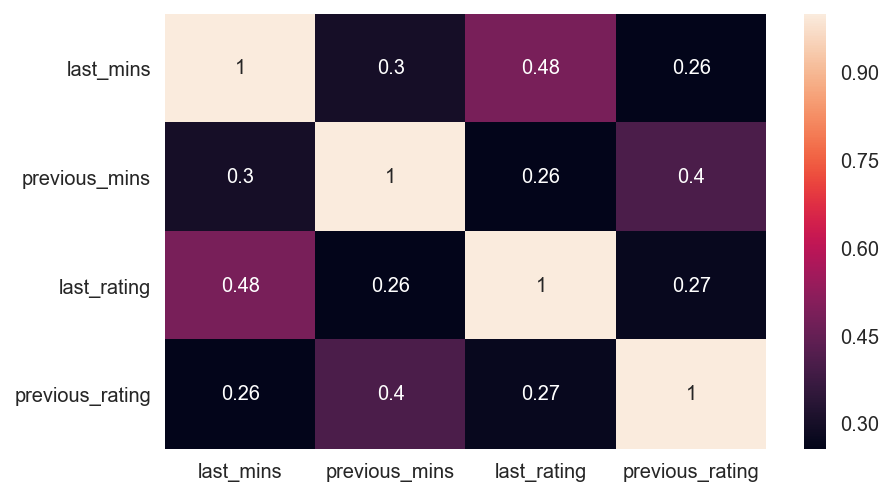

In [2639]:
sns.heatmap(mins_and_minutes.corr(), annot=True);

Things we can see here:

* There seems to be a positive correlation between last minutes and last rating. Which means that players who played more minutes in the last season, had a better overall rating. And the same happens with the previous season


* There seems to be also a positive correlation between previous ratings and last ratings. That means improvement.


* The relationship between mins is more diffuse. Even tough our plot indicates a positive correlation, and for some players, more mins in previous seasons implied more min in the last one, the chart it's a mess and we cannot back a positive correlation between variables


* Between the number of minutes played last season and the rating from the previous one, there seems to be a small relationship, in the sense that having more minutes in the last season could have been because of higher previous ratings. An even smaller relationship can be also seen the other way around, between the number of minutes played in previous season and the rating from the last one

So, the big question now is: 

**What if a player would have had more minutes in the last and previous seasons? What impact could that have had on their ratings and value?** 

The following function will try to find players in between a given range of values find their value change according to:

* That they already have stats above a certain threshold

* Having more minutes, and as a result of that, also an improvement on their ratings.

In [2250]:
def players_searcher(last_rating_thresh, prev_rating_thresh, min_thresh, new_season_minutes,
                     player=None, min_value=None, max_value=None):
    
    if player == None:
        working_data = final_with_preds[(final_with_preds.Pred_Value > min_value) & (final_with_preds.Pred_Value < max_value)]
    else:
        working_data = final_with_preds[final_with_preds.player.str.contains(player)]
    
    working_data_std = mega_std[mega_std.index.isin(list(mega_links[mega_links.Link.isin(list(working_data.player_link_tm))].index))]
    
    last_rating_threshold = np.percentile(mega_std.last_rating,last_rating_thresh)
    prev_rating_threshold = np.percentile(mega_std.previous_rating,prev_rating_thresh)
    minutes_threshold = np.percentile(mega_std.last_mins,min_thresh)
    minutes_high_threshold = np.percentile(mega_std.last_mins,new_season_minutes)
    prev_minutes_high_threshold = np.percentile(mega_std.previous_mins,new_season_minutes)
        
    filtered = working_data_std[(working_data_std.previous_rating >= prev_rating_threshold) & \
                            (working_data_std.last_rating >= last_rating_threshold) & \
                             (working_data_std.last_mins <= minutes_threshold)]
        
    prev_improvement = final_with_preds.previous_rating[final_with_preds.previous_mins >= \
                                                    np.percentile(final_with_preds.previous_mins,new_season_minutes)].mean() \
                       / final_with_preds.previous_rating[(final_with_preds.previous_mins <= \
                                                           np.percentile(final_with_preds.previous_mins,min_thresh)) \
                                                         & (final_with_preds.previous_mins >= 0)].mean()
    
    last_improvement = final_with_preds.last_rating[final_with_preds.last_mins >= \
                                                    np.percentile(final_with_preds.last_mins,new_season_minutes)].mean() \
                       / final_with_preds.last_rating[(final_with_preds.last_mins <= \
                                                     np.percentile(final_with_preds.last_mins,min_thresh)) \
                                                     & (final_with_preds.last_mins >= 0)].mean()
    
    filtered['last_rating'] = filtered.last_rating*last_improvement
    filtered['previous_rating'] = filtered.previous_rating*prev_improvement
    filtered['last_mins'] = minutes_high_threshold
    filtered['previous_mins'] = prev_minutes_high_threshold
    
    bag_preds = bagging_tree.predict(filtered)
    lasso_preds = lasso.predict(filtered)
    
    filtered['bagging_preds'] = np.exp(bag_preds)
    filtered['lasso_preds'] = np.exp(lasso_preds)
    
    filtered['player_link_tm'] = mega_links[mega_links.index.isin(list(filtered.index))]
    
    returner = filtered[['bagging_preds','lasso_preds','player_link_tm']].merge(final_with_preds,
                                                                              how='inner',
                                                                             on='player_link_tm')
    
    returner = returner[['player','player_link_tm','Pred_Value',
                         'bagging_preds','lasso_preds','highest_value']]#[(returner.bagging_preds > \
                                                                        # returner.Value) | \
                                                                        #(returner.lasso_preds > \
                                                                        #returner.Value)]
    
    return returner
    

In [2251]:
players_searcher(last_rating_thresh=50, prev_rating_thresh=70, min_thresh=30, new_season_minutes=80,
                     player=None, min_value=2500000, max_value=7500000)

,player,player_link_tm,Pred_Value,bagging_preds,lasso_preds,highest_value
0,Amin Younes,/amin-younes/profil/spieler/96167,3970972.0,4.030588e+06,1.267362e+07,6300000
1,Ridgeciano Haps,/ridgeciano-haps/profil/spieler/228444,3580593.0,3.501084e+06,1.883792e+06,5400000
2,Youssouf Sabaly,/youssouf-sabaly/profil/spieler/135492,7353986.0,7.895156e+06,6.296027e+06,9000000
3,Almamy Touré,/almamy-toure/profil/spieler/216181,5859929.0,5.751718e+06,5.674464e+06,7200000
4,Vukasin Jovanovic,/vukasin-jovanovic/profil/spieler/264140,3057802.0,2.997868e+06,4.383257e+06,4500000
5,Marcel Schmelzer,/marcel-schmelzer/profil/spieler/35208,3956044.0,4.106741e+06,3.298352e+06,9000000
6,Joe Bryan,/joe-bryan/profil/spieler/194460,4025480.0,4.027114e+06,5.799391e+06,5400000


Let's revisit then what this function does:

So, what this functions is doing is:

* Asks the user for several inputs:

1) A value range to search for players in between it

2) A last rating threshold that will be a percentile, in this case the 50 percentile for the last rating. And it will be filtering players ABOVE that rating

3) A previous rating threshold that works in the same way as the previous variable

4) A minutes threshold that will be looking for player that played less than the number according to that percentile. In this case 30

5) And a new season minutes threshold, that it’s kind of a promise of how much would be playing the player during the next season if buying him
 
* In second place, according to the last minutes threshold and the next season minutes threshold, it finds the relationship in ratings between those players. And knowing there’s a correlation, a player that played above the percentile 80 threshold will probably have a better score than those who played below the 30 percentile threshold. So if those scores were 8 and 6.5, it finds 8 over 6.5 and multiplies the filtered players rating by that value.
 
 
* Finally it updates the minutes played by the filtered players by the number of minutes corresponding to the number of minutes of the percentile specified
 
As a result it gives an updated prediction for the player values and a measure of how more could they be worth in case of playing more. This function may seem  not very useful right now, just updating those values, but it could be further improve by also updating:

* The league, if the player is moving to another one
* The current club to which he would me moving
* All the stats, according to more precise rates of improvement within the team's players real performance


## Individual models for different kind of players


In [103]:
dum_final_with_clubs.drop('outlier',inplace=True, axis=1)

In [ ]:
# Columns to be dropped later: Value, Pred_Value, Real_dif_preds, in_shape, current_log, double_trans, highest_value, prop_value_loss

In [104]:
dum_final_with_clubs = pd.concat([dum_final_with_clubs, final_with_clubs.highest_value],axis=1)

In [105]:
dum_final_with_clubs['prop_value_loss'] = np.abs(dum_final_with_clubs.highest_value - dum_final_with_clubs.Value) / dum_final_with_clubs.Value

In [106]:
dum_final_in_shape = dum_final_with_clubs[dum_final_with_clubs.in_shape == True]

In [107]:
dum_final_not_in_shape = dum_final_with_clubs[(dum_final_with_clubs.in_shape == False) &
                                             (dum_final_with_clubs.prop_value_loss < 50)]

In [108]:
y_in_shape = dum_final_in_shape.pop('current_log')
y_not_in_shape = dum_final_not_in_shape.pop('current_log')

In [109]:
dum_final_in_shape.drop(labels=['Value', 'Pred_Value', 'Real_dif_preds', 'in_shape', 'double_trans', 
                                'highest_value', 'prop_value_loss'], axis=1, inplace=True)

dum_final_not_in_shape.drop(labels=['Value', 'Pred_Value', 'Real_dif_preds', 'in_shape', 'double_trans', 
                                'highest_value', 'prop_value_loss'], axis=1, inplace=True)

In [110]:
X_train_in_shape, X_test_in_shape, y_train_in_shape, y_test_in_shape = \
train_test_split(dum_final_in_shape, y_in_shape, test_size = 0.4, random_state=123)

X_train_not_in_shape, X_test_not_in_shape, y_train_not_in_shape, y_test_not_in_shape = \
train_test_split(dum_final_not_in_shape, y_not_in_shape, test_size = 0.4, random_state=123)


In [193]:
scaler_fit = StandardScaler()
scaler_fit.fit(X_train_in_shape)
X_train_in_shape = pd.DataFrame(scaler_fit.transform(X_train_in_shape), 
                                columns=X_train_in_shape.columns,
                               index=X_train_in_shape.index)

X_test_in_shape = pd.DataFrame(scaler_fit.transform(X_test_in_shape), 
                                columns=X_test_in_shape.columns,
                               index=X_test_in_shape.index)

In [169]:
scaler_non = StandardScaler()
X_train_not_in_shape = pd.DataFrame(scaler_non.fit_transform(X_train_not_in_shape), 
                                columns=X_train_not_in_shape.columns,
                               index=X_train_not_in_shape.index)

X_test_not_in_shape = pd.DataFrame(scaler_non.transform(X_test_not_in_shape), 
                                columns=X_test_not_in_shape.columns,
                               index=X_test_not_in_shape.index)

In [114]:
def alpha_scores(model, alpha_values, X_train, y_train):
    scores = []
    for alpha in alpha_values:
        model_ = model(alpha)
        scores.append(np.mean(cross_val_score(
            model_, X_train, y_train, cv=5)))
    return scores

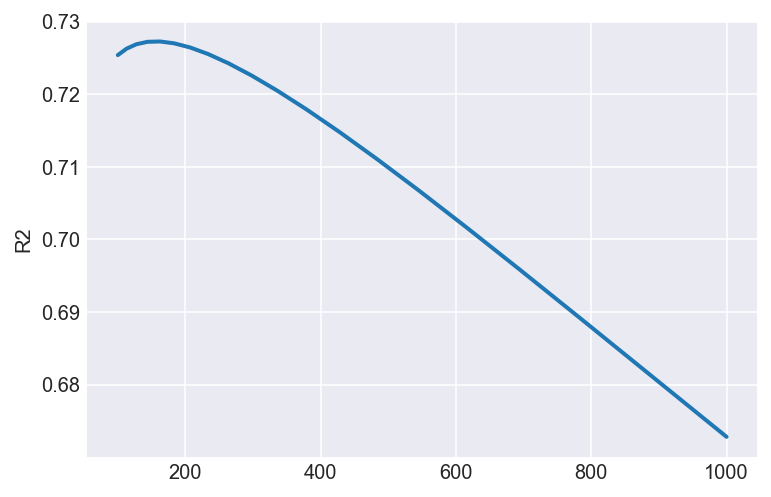

In [116]:
alpha_values = np.logspace(2,3,20)
scores = alpha_scores(Ridge, alpha_values, X_train_in_shape, y_train_in_shape)

plt.plot(alpha_values, [score for score in scores], lw=2)
plt.ylabel('R2')
plt.show()

In [170]:
ridge_in_shape = RidgeCV(alphas=np.logspace(2,2.5,20), cv=5)

ridge_in_shape.fit(X_train_in_shape, y_train_in_shape)

print('Best alpha:', ridge_in_shape.alpha_)

print('Training score:', ridge_in_shape.score(X_train_in_shape, y_train_in_shape))

print('Test score:', ridge_in_shape.score(X_test_in_shape, y_test_in_shape))

scores = cross_val_score(ridge_in_shape, X_train_in_shape, y_train_in_shape, cv=5)
print('Mean cross-validated training score:', scores.mean())

/Users/gonzaloferreiro/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



Best alpha: 152.83067326587687
Training score: 0.9504707466359503
Test score: 0.646415411616599


/Users/gonzaloferreiro/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



Mean cross-validated training score: 0.7251885092715723


/Users/gonzaloferreiro/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



In [129]:
in_shape_coef = pd.DataFrame(np.abs(ridge_in_shape.coef_),index=X_train_in_shape.columns,columns=['coef'])

In [130]:
in_shape_coef.sort_values(by='coef',ascending=False).head(10)

,coef
last_mins,0.117979
last_rating,0.071695
previous_mins,0.067502
tw_index,0.064503
Under Continental Winner,0.063794
team_clas_Top 50,0.062330
age_group_31-34,0.055363
last_dribbles,0.054859
last_passes,0.051914
previous_rating,0.051824


Very good scores with a very simple model for those players that are right now at the highest value of their career. We are getting a different set of features than the one we got when trying to predict the residuals from our original model. Which is interesting, since it talks about a bast range of features with different predicting power.

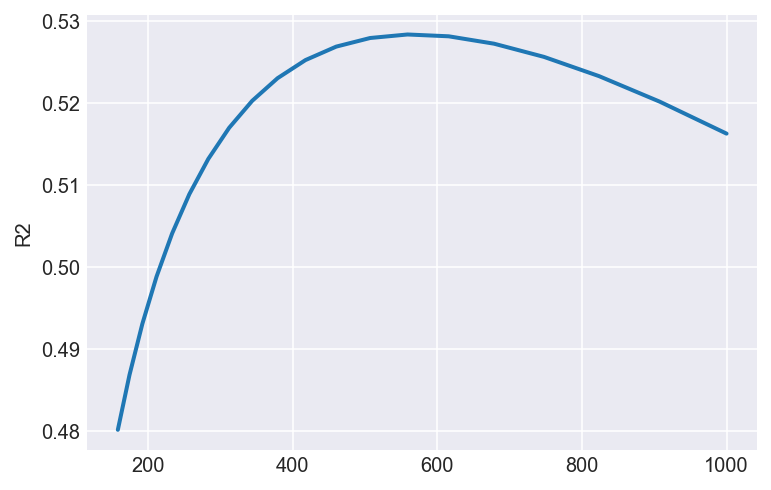

In [118]:
alpha_values = np.logspace(2.2,3,20)
scores = alpha_scores(Ridge, alpha_values, X_train_not_in_shape, y_train_not_in_shape)

plt.plot(alpha_values, [score for score in scores], lw=2)
plt.ylabel('R2')
plt.show()

In [171]:
ridge_not_in_shape = RidgeCV(alphas=np.logspace(2.2,3,20), cv=5)

ridge_not_in_shape.fit(X_train_not_in_shape, y_train_not_in_shape)

print('Best alpha:', ridge_not_in_shape.alpha_)

print('Training score:', ridge_not_in_shape.score(X_train_not_in_shape, y_train_not_in_shape))

print('Test score:', ridge_not_in_shape.score(X_test_not_in_shape, y_test_not_in_shape))

scores = cross_val_score(ridge_not_in_shape, X_train_not_in_shape, y_train_not_in_shape, cv=5)
print('Mean cross-validated training score:', scores.mean())

/Users/gonzaloferreiro/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



Best alpha: 558.9441576403378
Training score: 0.8373210770159318
Test score: 0.5672079863255806


/Users/gonzaloferreiro/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/gonzaloferreiro/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



Mean cross-validated training score: 0.5179038654420175


In [126]:
not_in_shape_coef = pd.DataFrame(np.abs(ridge_not_in_shape.coef_), columns=["coef"],index=X_train_not_in_shape.columns)

In [127]:
not_in_shape_coef.sort_values(by='coef',ascending=False).head(10)

,coef
age_group_Plus_35,0.084036
Under Continental Winner,0.043418
previous_mins,0.039400
last_mins,0.039336
previous_mom_permin,0.038582
league_Premier League (ENG),0.038148
previous_passes,0.036506
tw_index,0.035528
nat_team_min,0.035072
league_La Liga (SPA),0.033560


For players not in shape (players which lost value during their career) we are getting lower scores, but a completely different set of variables when seeing the feature importance. The interesting thing is that again we are getting different features that the ones we had when we tried to predict the residuals from the previous model. So we can say that we have a really interesting set of features, with different kind of predicting power.

In [ ]:
# Searching for a player in shape and checking predicting value versus recent selling price
# Original target value: 22.50mm
# Recent selling price: 28.80mm
# Predcited price: 34.30mm

In [232]:
searcher = final_with_preds[final_with_preds.lastname == 'Demirbay']

In [234]:
found_you = dum_final_in_shape[(dum_final_in_shape.height == searcher.height.item()) &
                  (dum_final_in_shape.previous_mom_permin == searcher.previous_mom_permin.item())]

In [237]:
np.exp(ridge_in_shape.predict(X_test_in_shape.loc[[331],:]))

array([34331975.02048054])